### Context  
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the bank poorly. Based on this, the Operations team wants to upgrade the service delivery model to ensure that customer queries are resolved faster. The Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.  

### Objective  
To identify different segments in the existing customers, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.  

### Data Description  
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online, and through a call center).  

### Data Dictionary  
- **Sl_No**: Primary key of the records  
- **Customer Key**: Customer identification number  
- **Average Credit Limit**: Average credit limit of each customer for all credit cards  
- **Total credit cards**: Total number of credit cards possessed by the customer  
- **Total visits bank**: Total number of visits that the customer made (yearly) personally to the bank  
- **Total visits online**: Total number of visits or online logins made by the customer (yearly)  
- **Total calls made**: Total number of calls made by the customer to the bank or its customer service department (yearly)  

In [303]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
%matplotlib inline


In [142]:
df = pd.read_excel("D:/Data Science/Module-6_Unsupervised_Learning/project-6/Credit Card Customer Data.xlsx")
data = df.copy()
df.sample(10)

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
521    522         91242             70000                   4   
133    134         14248             10000                   3   
598    599         13720             64000                   5   
542    543         75417             47000                   5   
397    398         88207             49000                   5   
599    600         72339             57000                   6   
50      51         51182             13000                   1   
583    584         47703             52000                   6   
475    476         65781             45000                   5   
444    445         41266             67000                   6   

     Total_visits_bank  Total_visits_online  Total_calls_made  
521                  3                    2                 2  
133                  1                    5                 9  
598                  4                    1                 2  
542                  5                    1                 2  
397                  3                    2                 0  
599                  2                    2                 0  
50                   0                    5                 9  
583                  2                    0                 0  
475                  5                    2                 2  
444                  5                    2                 0

In [143]:
df.shape

(660, 7)

In [144]:
for col in df.columns:
    print(f"{col} - {df[col].nunique()}")


Sl_No - 660
Customer Key - 655
Avg_Credit_Limit - 110
Total_Credit_Cards - 10
Total_visits_bank - 6
Total_visits_online - 16
Total_calls_made - 11


In [145]:
df[df['Customer Key'].isin(data[data['Customer Key'].duplicated()]['Customer Key'].tolist())].sort_values('Customer Key')

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
48      49         37252              6000                   4   
432    433         37252             59000                   6   
4        5         47437            100000                   6   
332    333         47437             17000                   7   
411    412         50706             44000                   4   
541    542         50706             60000                   7   
391    392         96929             13000                   4   
398    399         96929             67000                   6   
104    105         97935             17000                   2   
632    633         97935            187000                   7   

     Total_visits_bank  Total_visits_online  Total_calls_made  
48                   0                    2                 8  
432                  2                    1                 2  
4                    0                   12                 3  
332                  3                    1                 0  
411                  5                    0                 2  
541                  5                    2                 2  
391                  5                    0                 0  
398                  2                    2                 2  
104                  1                    2                10  
632                  1                    7                 0

The records for the same Customer Key appear to be significantly different from each other. This could be due to an error in Customer Key assignment or the absence of a current_version_indicator in the dataset. For now, I will treat these as separate customers. After clustering, I will analyze the groups associated with these sets of records.

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [148]:
df.describe()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
count  660.000000    660.000000        660.000000          660.000000   
mean   330.500000  55141.443939      34574.242424            4.706061   
std    190.669872  25627.772200      37625.487804            2.167835   
min      1.000000  11265.000000       3000.000000            1.000000   
25%    165.750000  33825.250000      10000.000000            3.000000   
50%    330.500000  53874.500000      18000.000000            5.000000   
75%    495.250000  77202.500000      48000.000000            6.000000   
max    660.000000  99843.000000     200000.000000           10.000000   

       Total_visits_bank  Total_visits_online  Total_calls_made  
count         660.000000           660.000000        660.000000  
mean            2.403030             2.606061          3.583333  
std             1.631813             2.935724          2.865317  
min             0.000000             0.000000          0.000000  
25%             1.000000             1.000000          1.000000  
50%             2.000000             2.000000          3.000000  
75%             4.000000             4.000000          5.000000  
max             5.000000            15.000000         10.000000

# Data Preprocessing

## Duplicate value check and Missing value treatment

In [151]:
df.duplicated().sum()

0

In [152]:
df.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [153]:
df.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

# Feature Engineering

In [155]:

df = df.drop(['Sl_No','Customer Key'],axis=1)

In [156]:
df.columns

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made'],
      dtype='object')

In [157]:
df

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0              100000                   2                  1   
1               50000                   3                  0   
2               50000                   7                  1   
3               30000                   5                  1   
4              100000                   6                  0   
..                ...                 ...                ...   
655             99000                  10                  1   
656             84000                  10                  1   
657            145000                   8                  1   
658            172000                  10                  1   
659            167000                   9                  0   

     Total_visits_online  Total_calls_made  
0                      1                 0  
1                     10                 9  
2                      3                 4  
3                      1                 4  
4                     12                 3  
..                   ...               ...  
655                   10                 0  
656                   13                 2  
657                    9                 1  
658                   15                 0  
659                   12                 2  

[660 rows x 5 columns]

# Outlier Detection and Treatment 

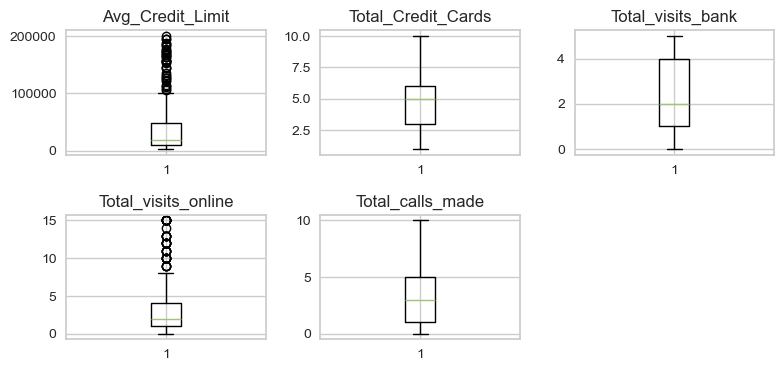

In [159]:

for i,col in enumerate(df.columns):
    plt.subplot(3,3,i+1)
    plt.boxplot(df[col],whis=1.5)
    plt.tight_layout()
    plt.title(col)


# plt.show()

In [160]:
for col in df.columns:
    print(df[col].value_counts())

Avg_Credit_Limit
8000      35
6000      31
9000      28
13000     28
19000     26
          ..
43000      1
146000     1
155000     1
200000     1
167000     1
Name: count, Length: 110, dtype: int64
Total_Credit_Cards
4     151
6     117
7     101
5      74
2      64
1      59
3      53
10     19
9      11
8      11
Name: count, dtype: int64
Total_visits_bank
2    158
1    112
0    100
3    100
5     98
4     92
Name: count, dtype: int64
Total_visits_online
2     189
0     144
1     109
4      69
5      54
3      44
15     10
7       7
10      6
12      6
8       6
11      5
13      5
9       4
14      1
6       1
Name: count, dtype: int64
Total_calls_made
4     108
0      97
2      91
1      90
3      83
6      39
7      35
9      32
8      30
5      29
10     26
Name: count, dtype: int64


In [161]:
import numpy as np

Q1 = df['Avg_Credit_Limit'].quantile(0.25)
Q3 = df['Avg_Credit_Limit'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['Avg_Credit_Limit']=np.where( df['Avg_Credit_Limit']>upper_bound,upper_bound,df['Avg_Credit_Limit'])


I am not changing anything of Total_visits_online column.

# 2 **Exploratory Data Analysis**

## 2.1 **Univariate Analysis**

In [165]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="red"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="yellow", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="green", linestyle="-"
    )  # Add median to the histogram


# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count , 5))
    else:
        plt.figure(figsize=(n , 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        hue=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage



def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)

    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count , 7))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.savefig(f'D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/3_{predictor}_{target}.jpg',dpi=100,bbox_inches='tight')
    # plt.show()


def box_plot_two_variable(data, predictor1,predictor2):
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Correct dimensions

    # Boxplot with outliers
    axs[0].set_title(f"Boxplot of {predictor1} vs {predictor2}")
    sns.boxplot(data=data, x=predictor2, y=predictor1,ax=axs[0], palette="gist_rainbow")

    # Boxplot without outliers
    axs[1].set_title(f"Boxplot (without outliers) of {predictor1} vs {predictor2}")
    sns.boxplot(
        data=data,
        x=predictor2,
        y=predictor1,
        ax=axs[1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    
    plt.savefig(f'D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/4_{predictor1}_{predictor2}.jpg',dpi=100,bbox_inches='tight')

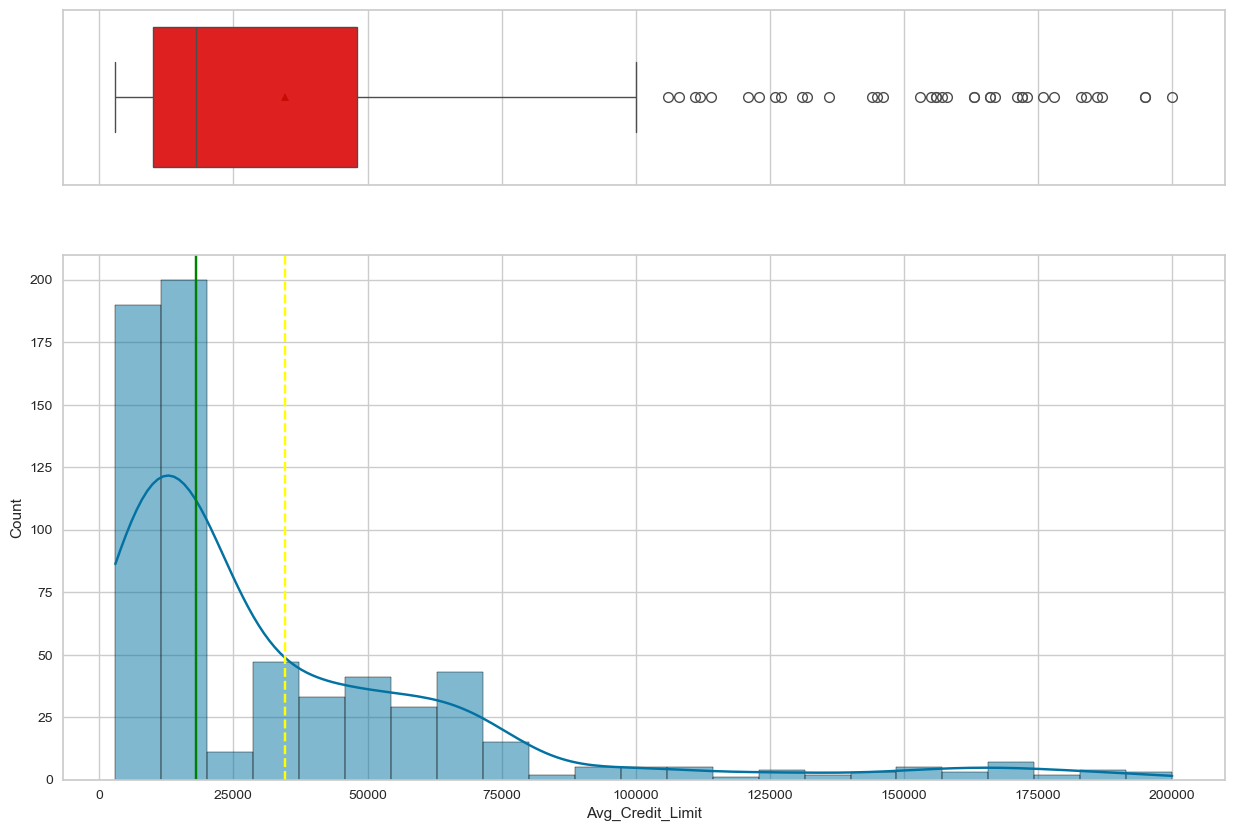

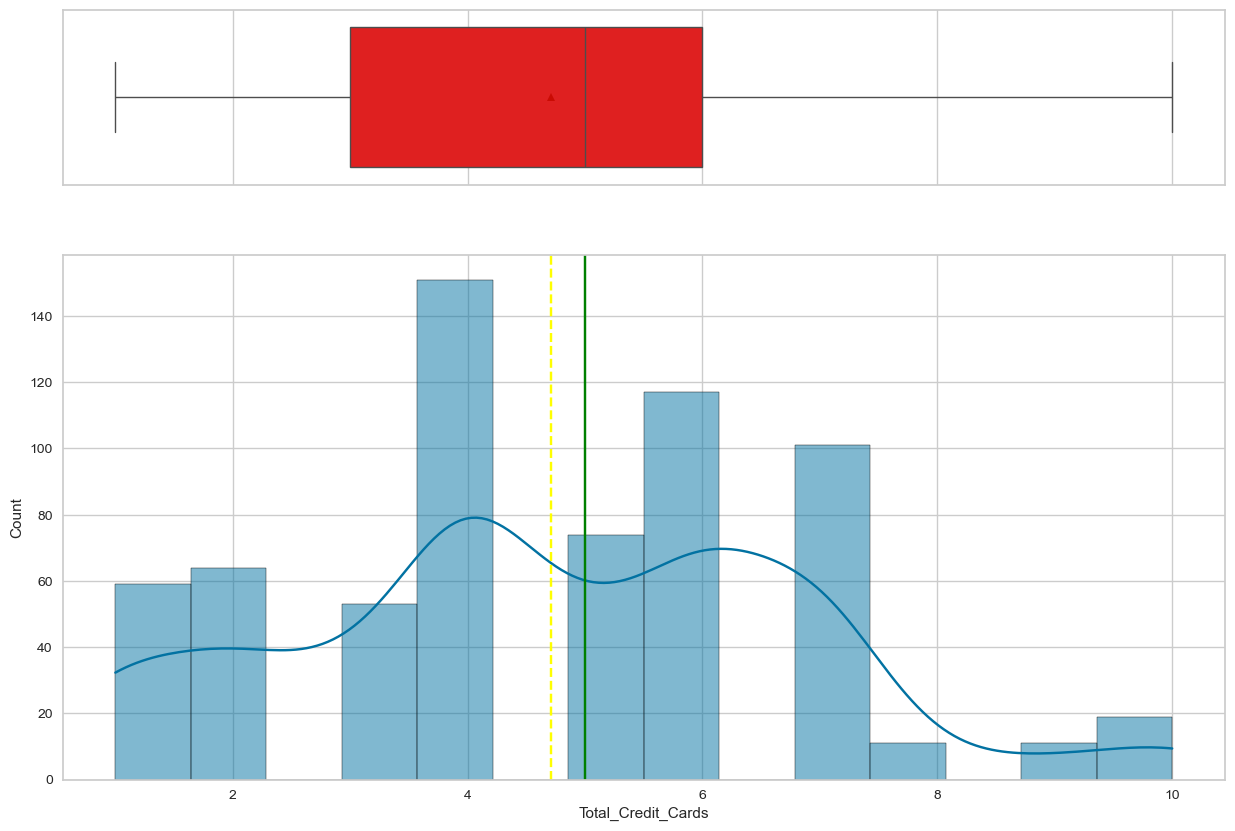

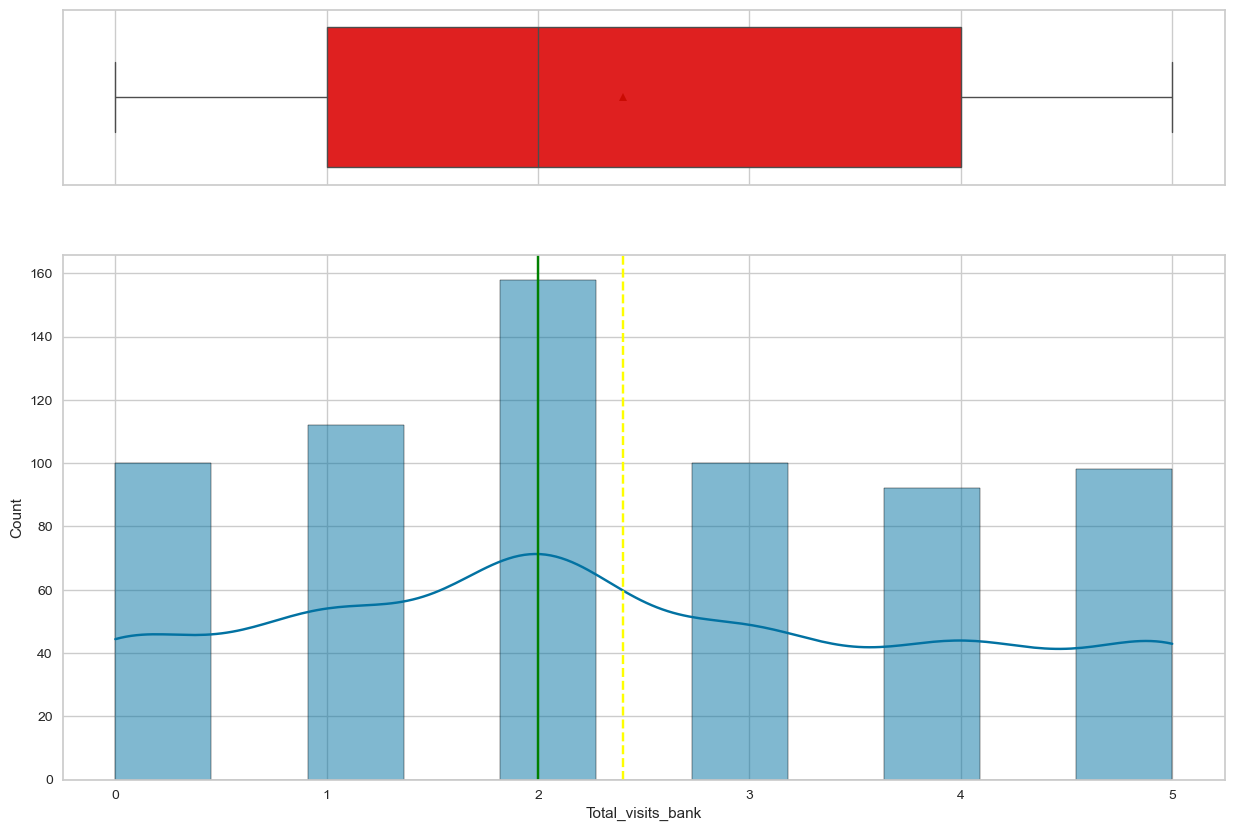

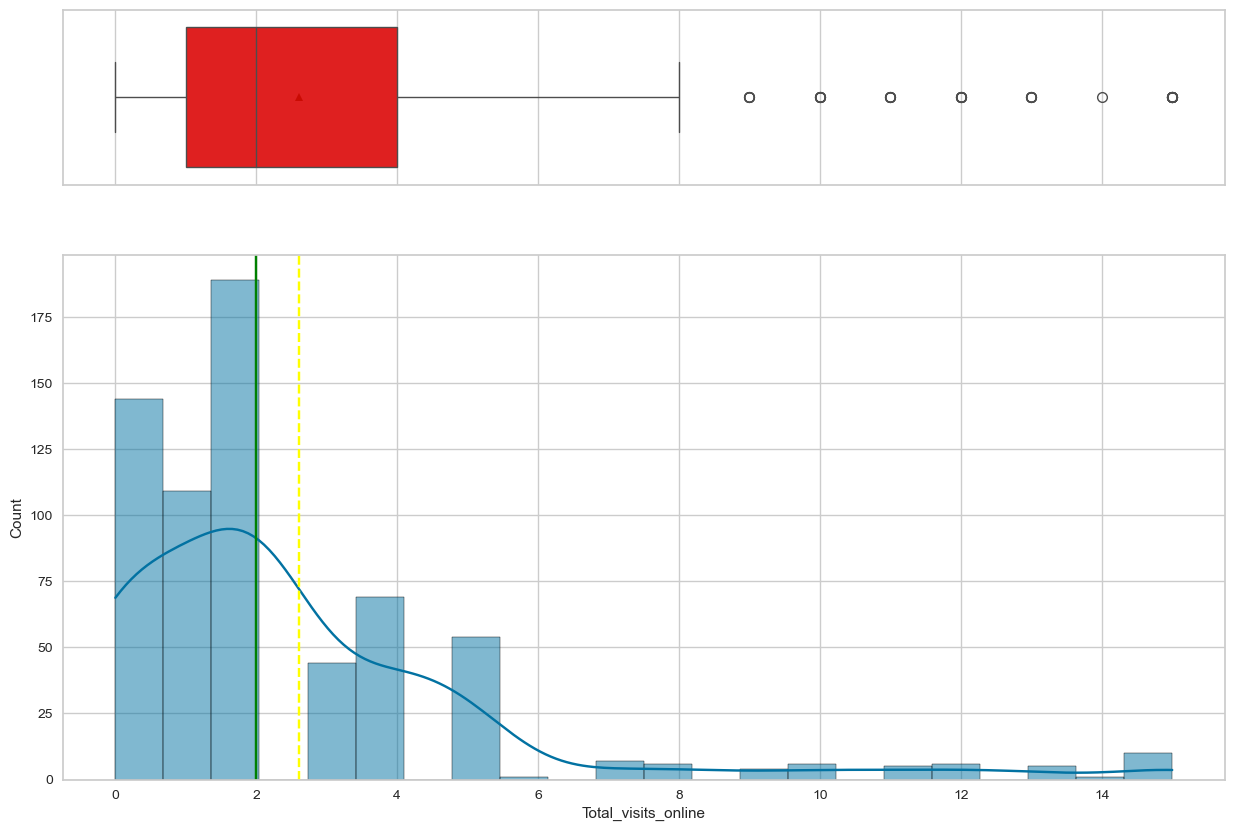

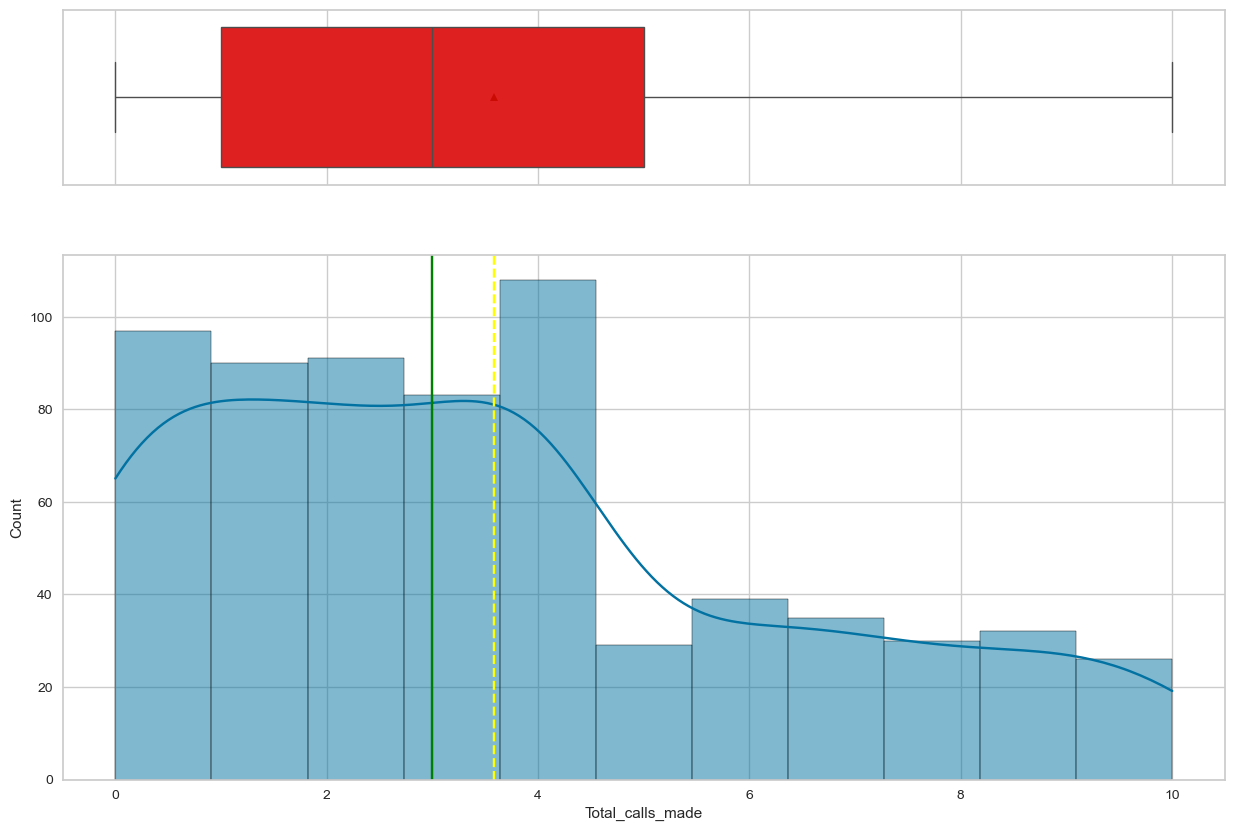

In [166]:
for col in df.columns:
    histogram_boxplot(data, col, kde=True)  # Pass column data and column name
    plt.savefig(f'D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/1_{col}.jpg') 

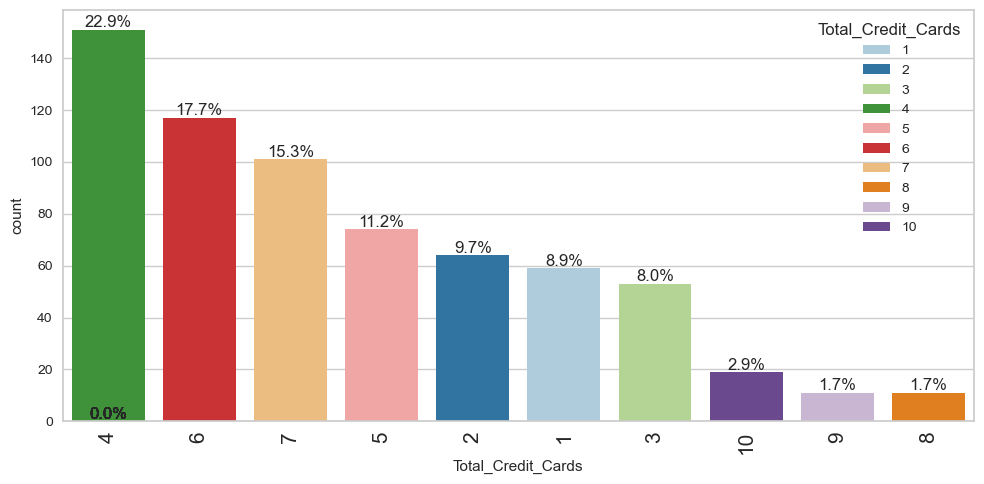

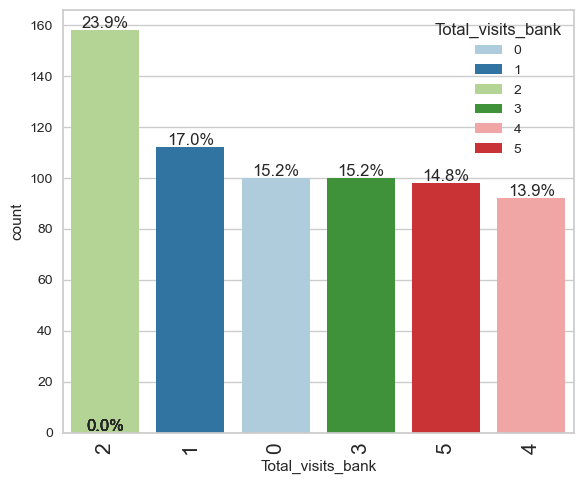

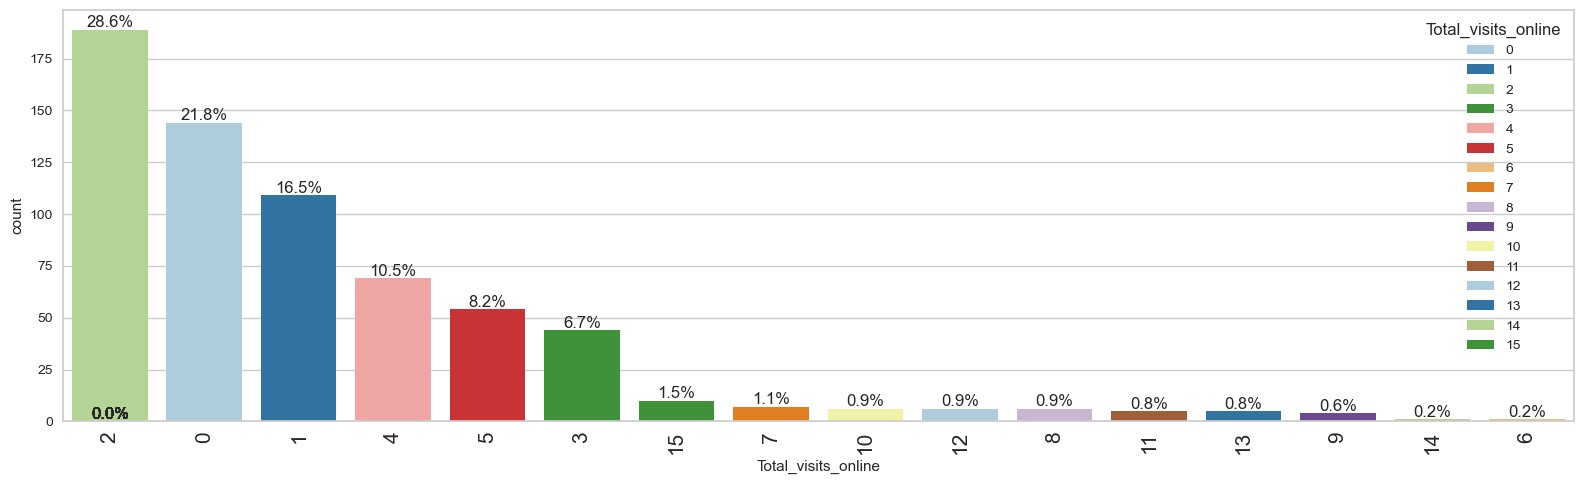

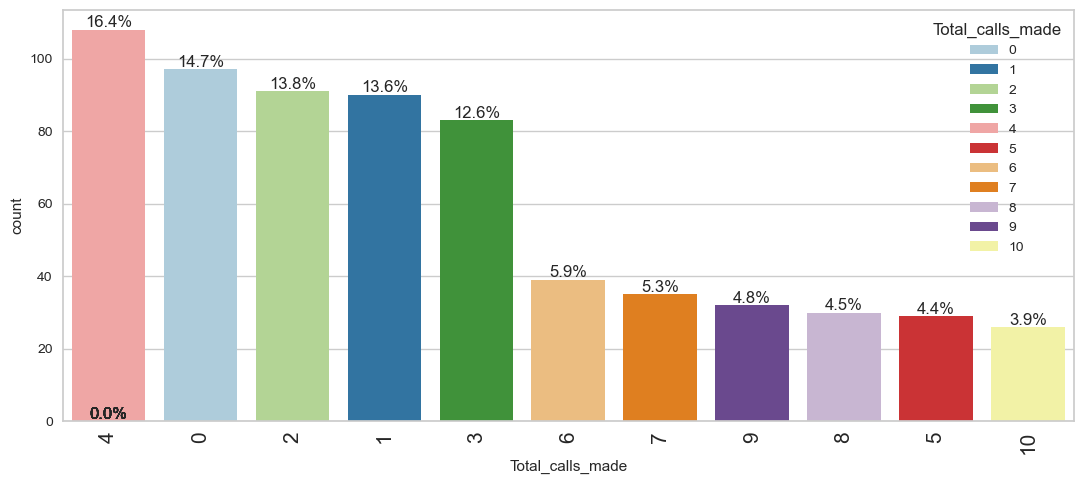

In [167]:
cols = ['Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made']
for col in cols:
    labeled_barplot(data,col,perc=True)
    plt.tight_layout()  # Prevent padding issues
    plt.savefig(f'D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/2_{col}.jpg',dpi=100)

### 2.2 **Bivariate Analysis**

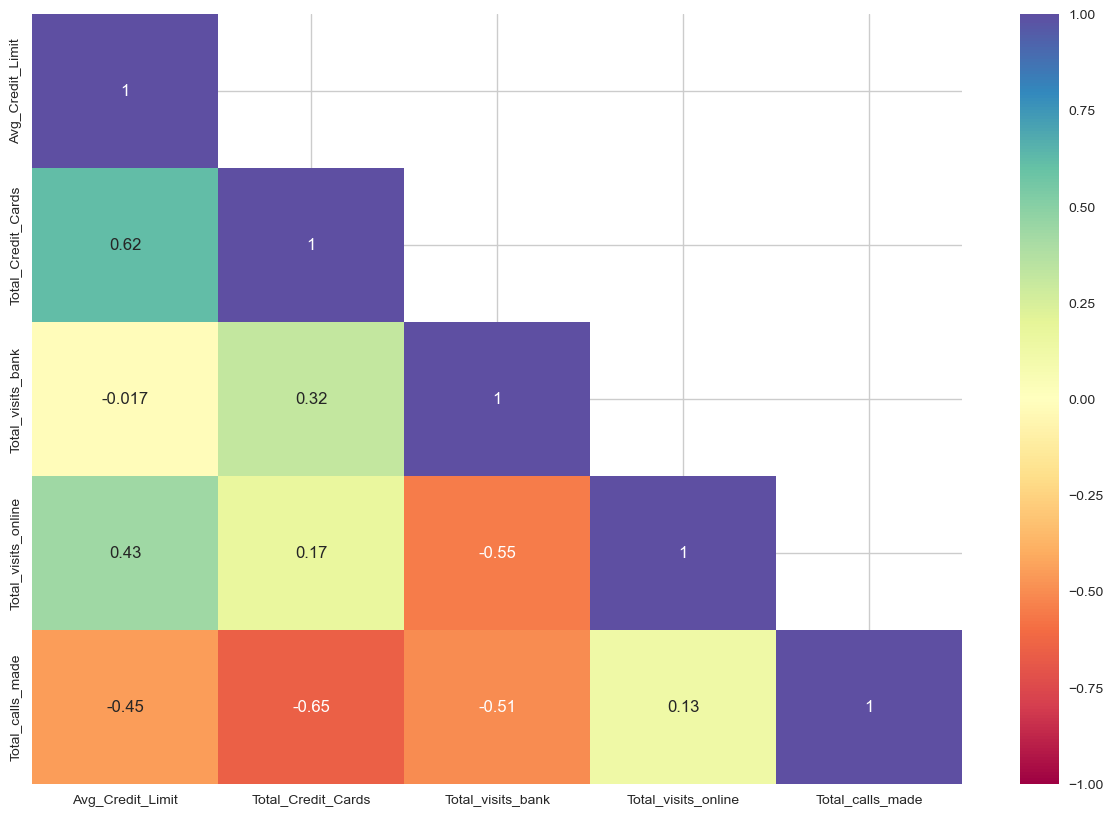

In [169]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),vmax=+1,vmin=-1, cmap="Spectral",annot=True, mask = np.triu(df.corr(), +1))
plt.savefig(f'D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/heatmap.jpg',dpi=100)

<Figure size 1000x600 with 0 Axes>

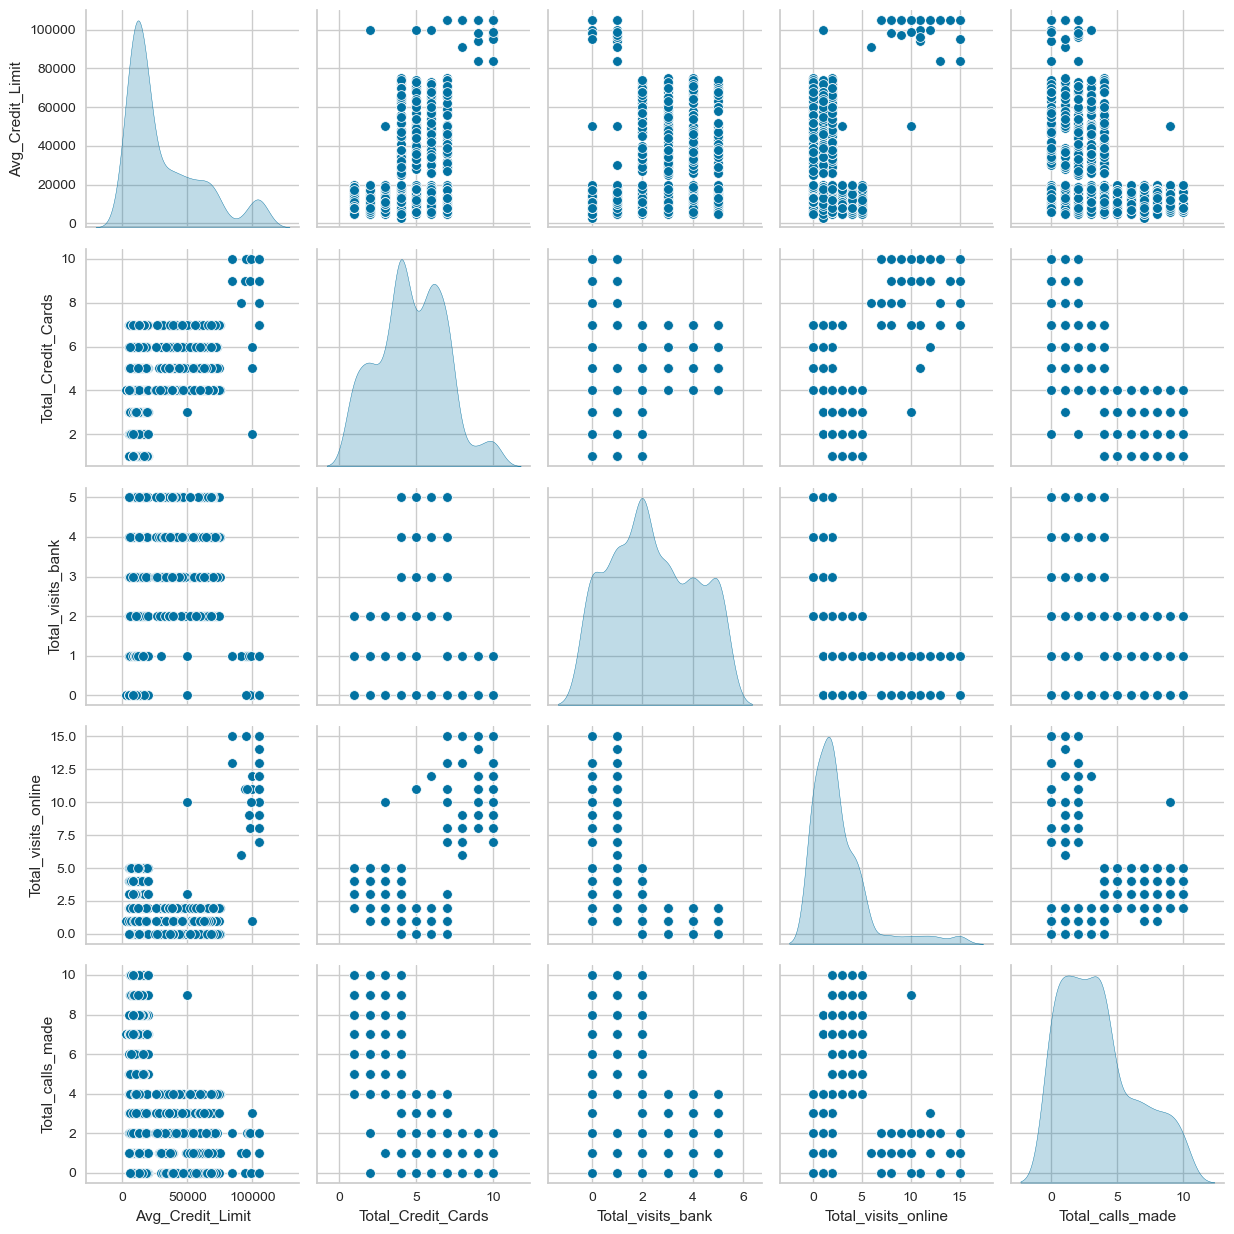

In [170]:
plt.figure(figsize=(10,6))
pairplot = sns.pairplot(df,diag_kind='kde')
plt.tight_layout()
plt.savefig(f'D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/pairplot.jpg',dpi=100)


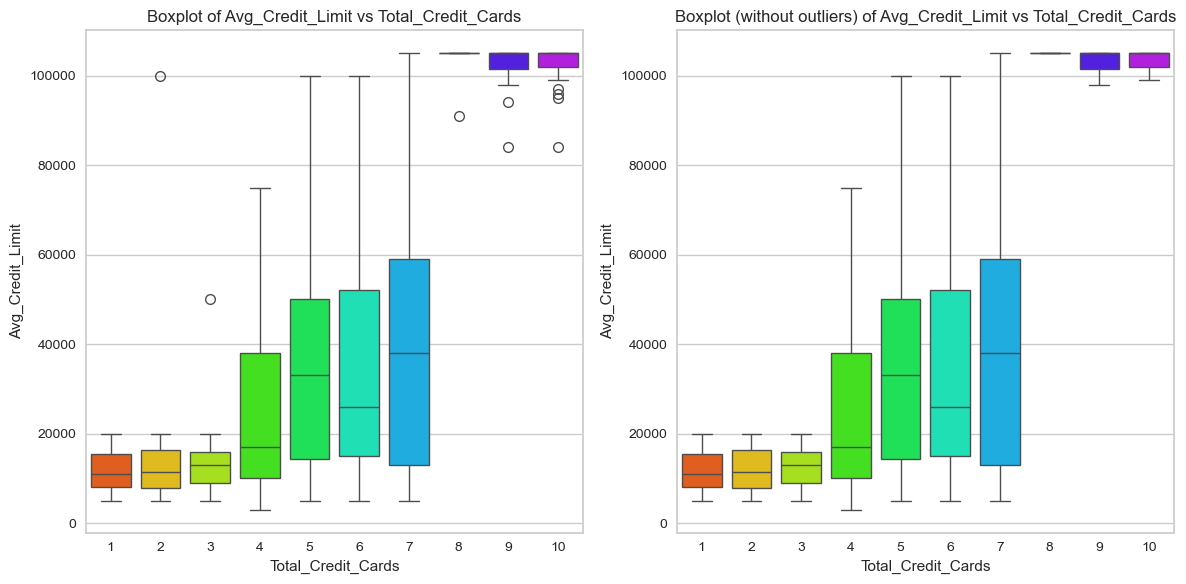

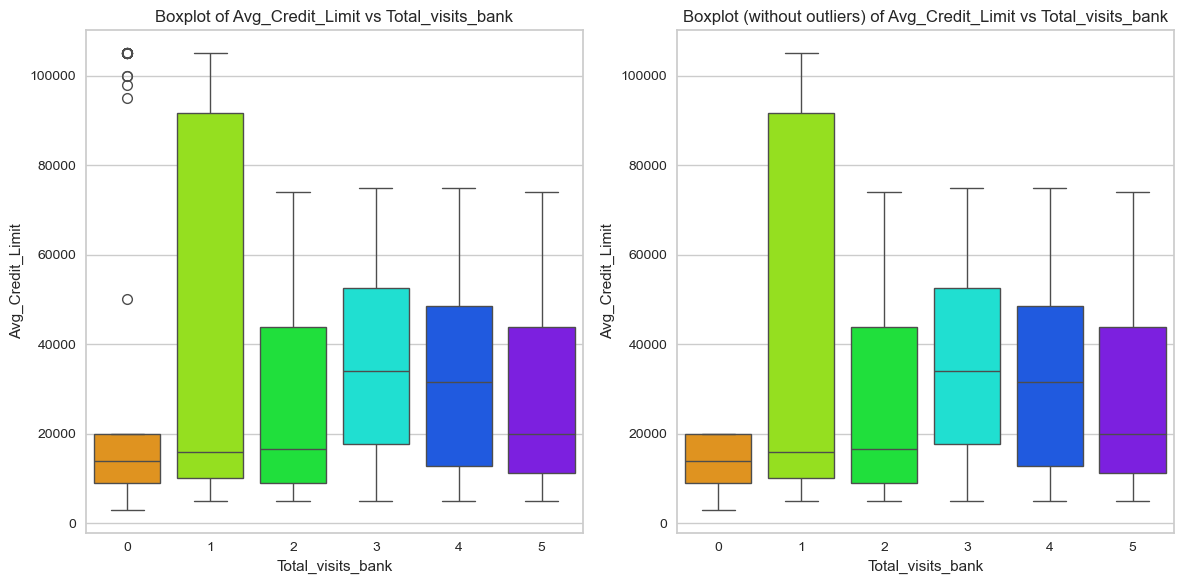

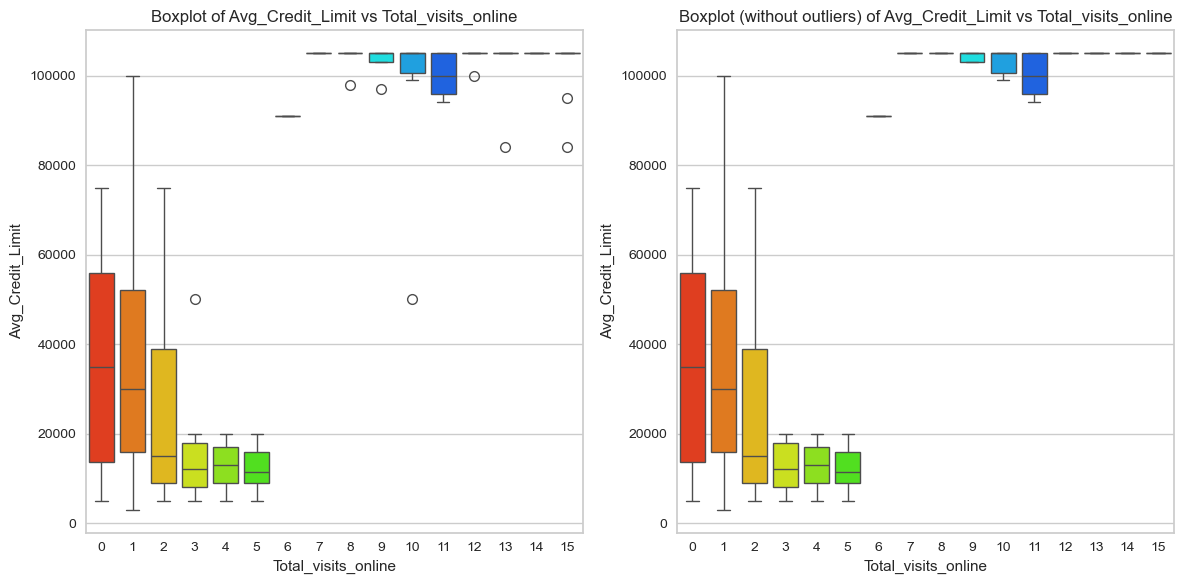

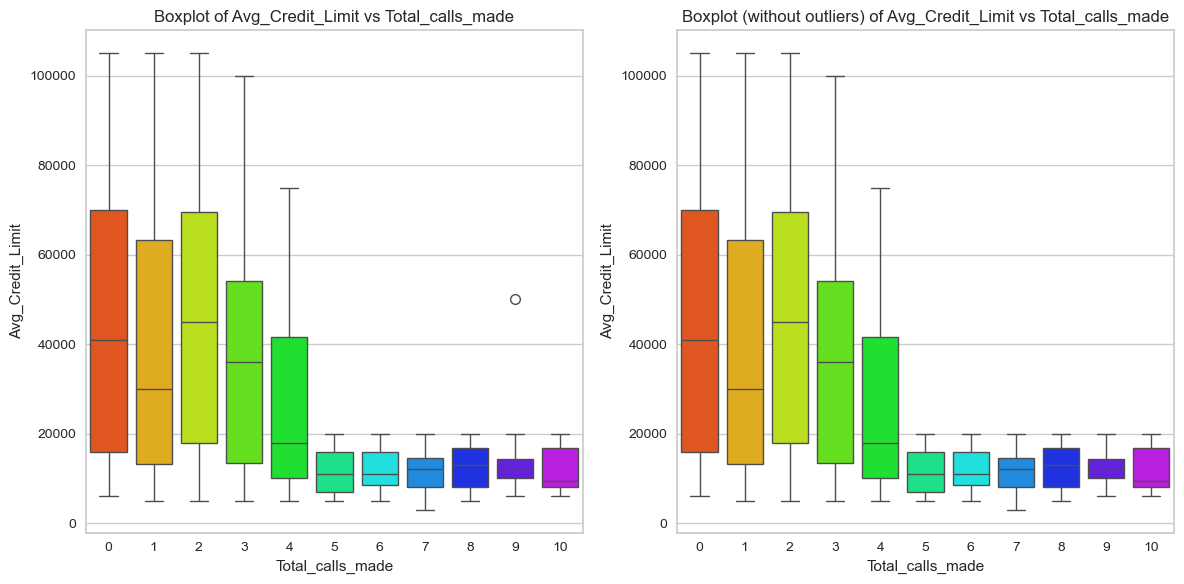

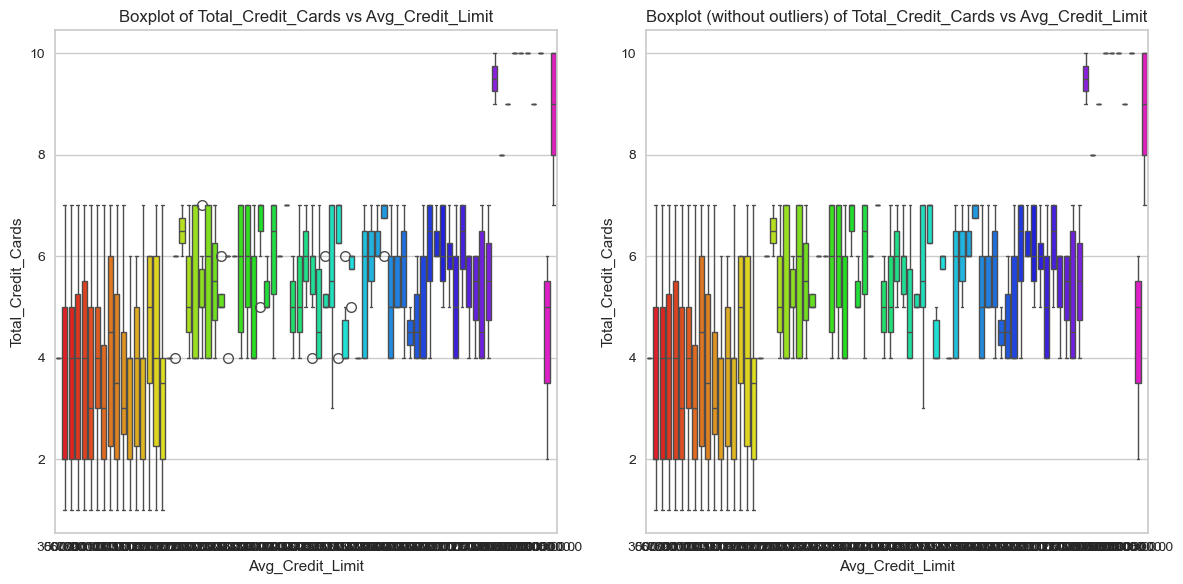

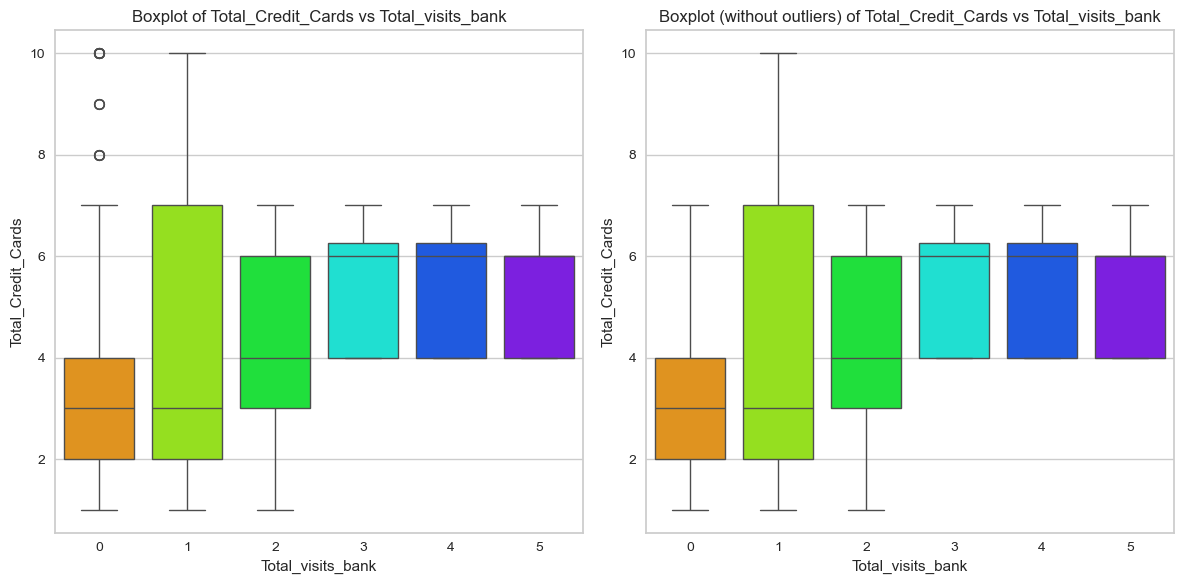

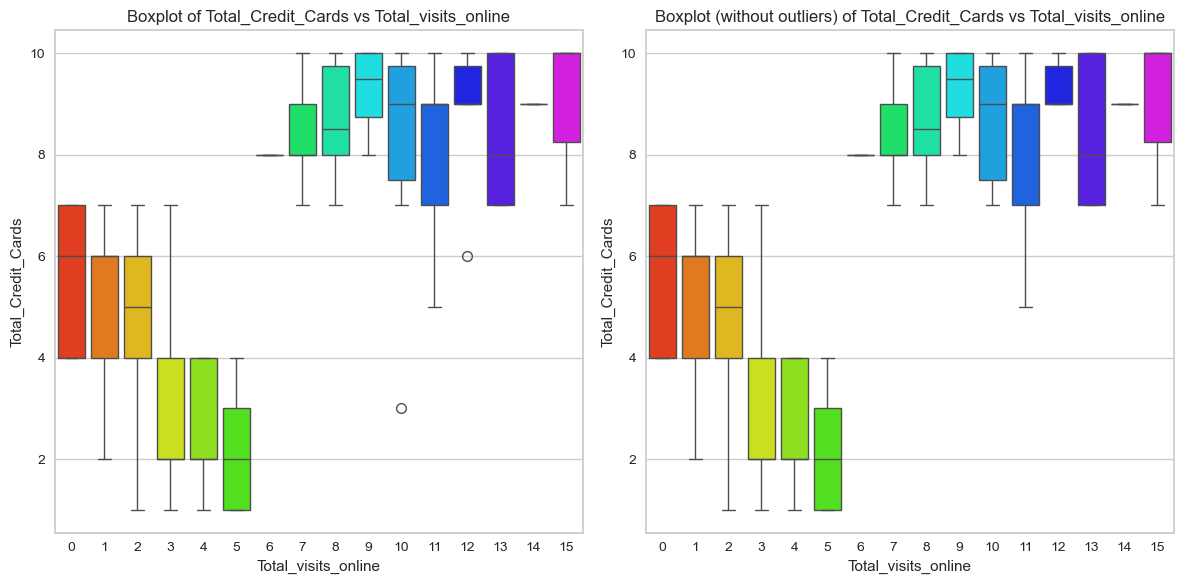

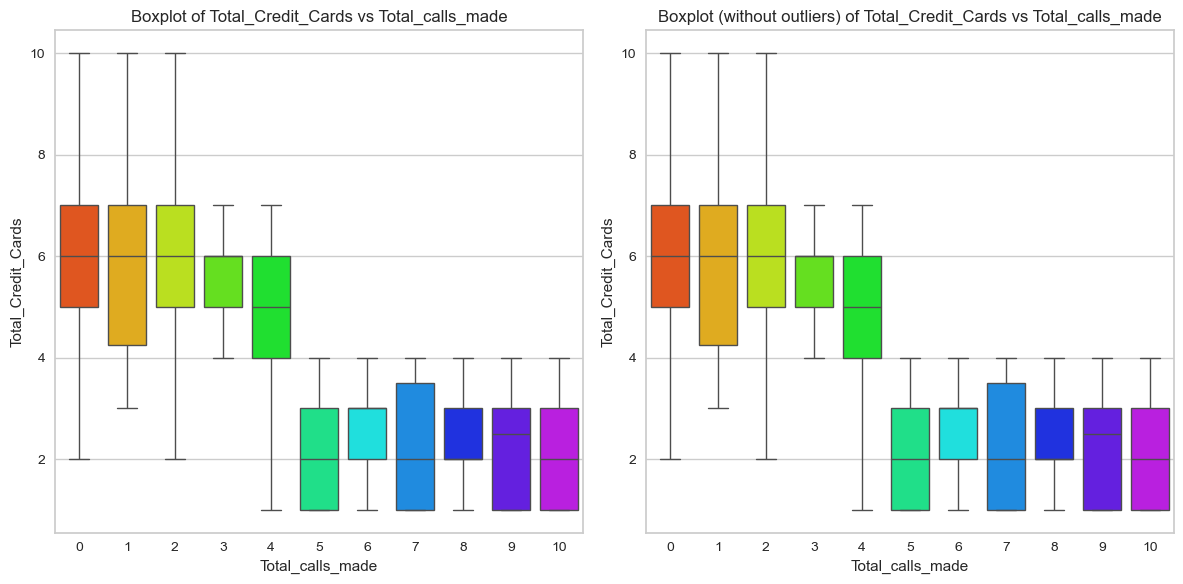

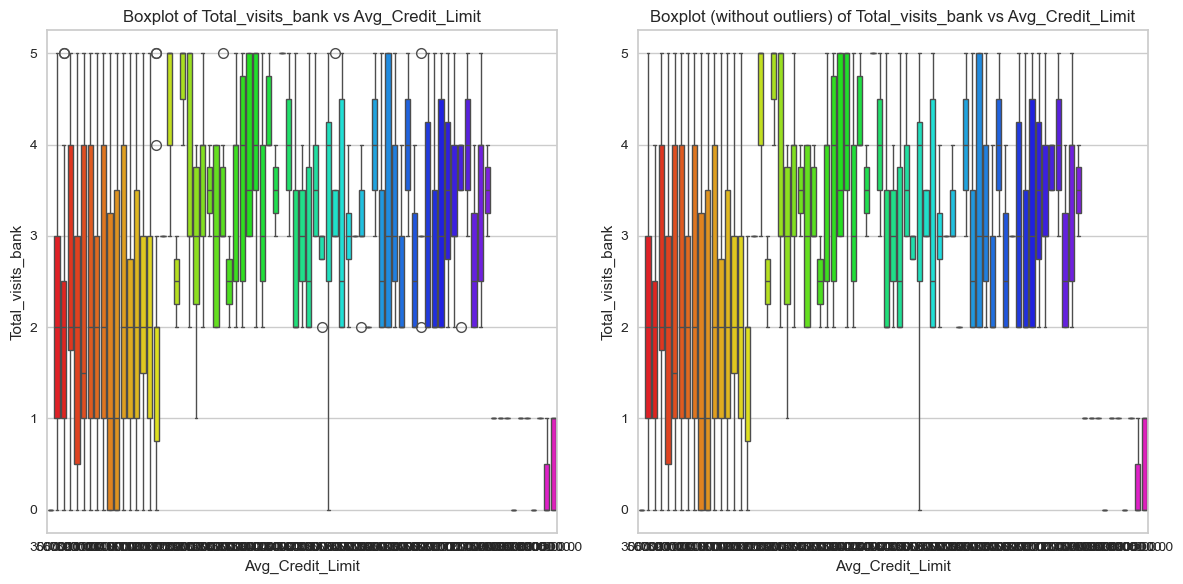

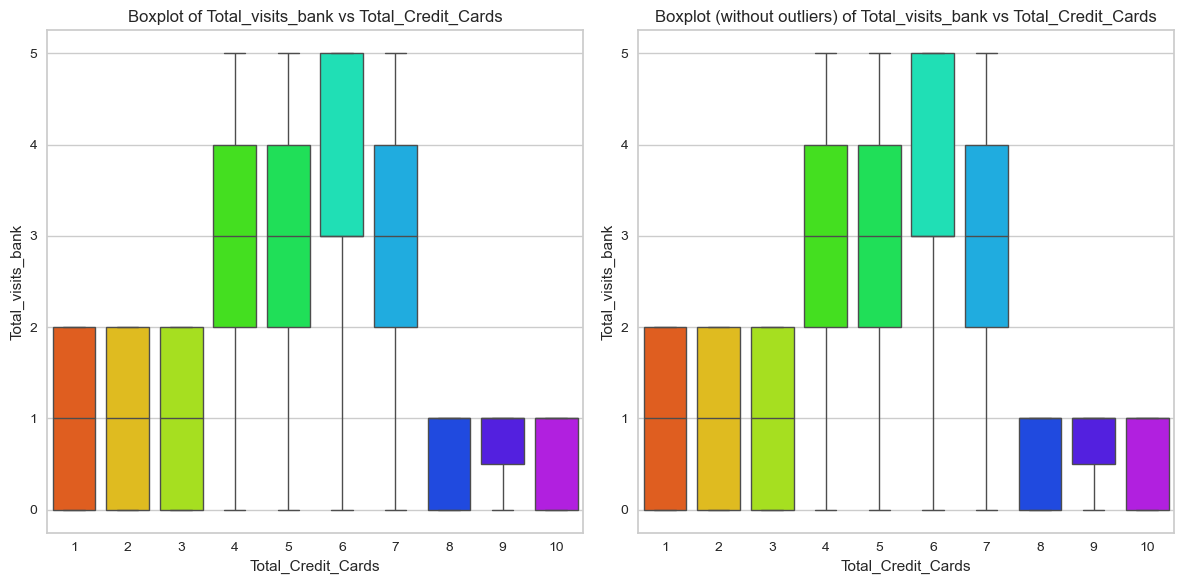

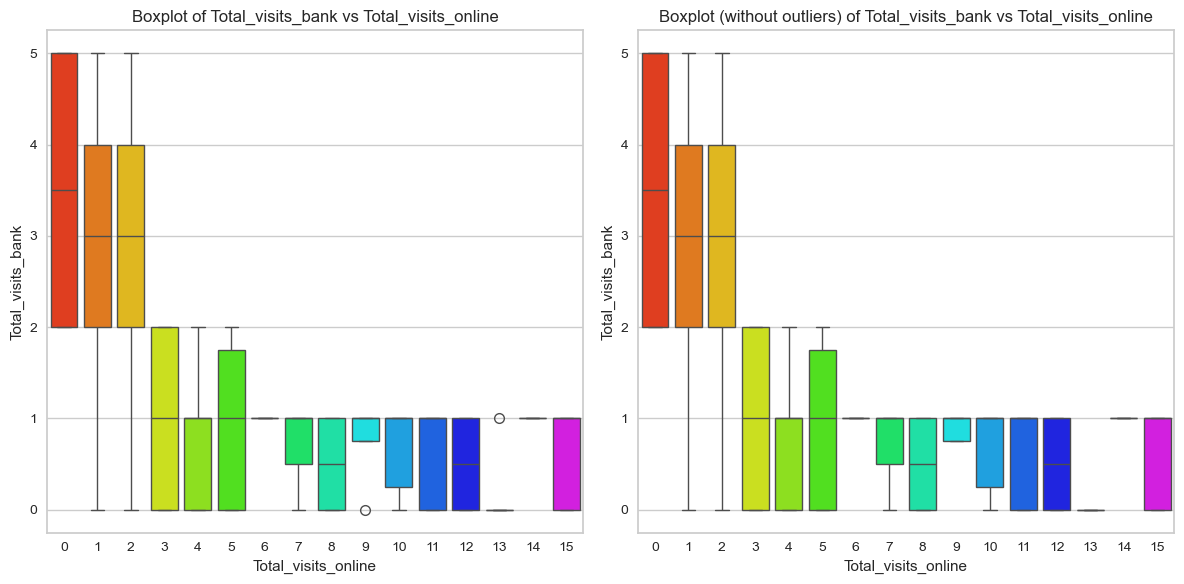

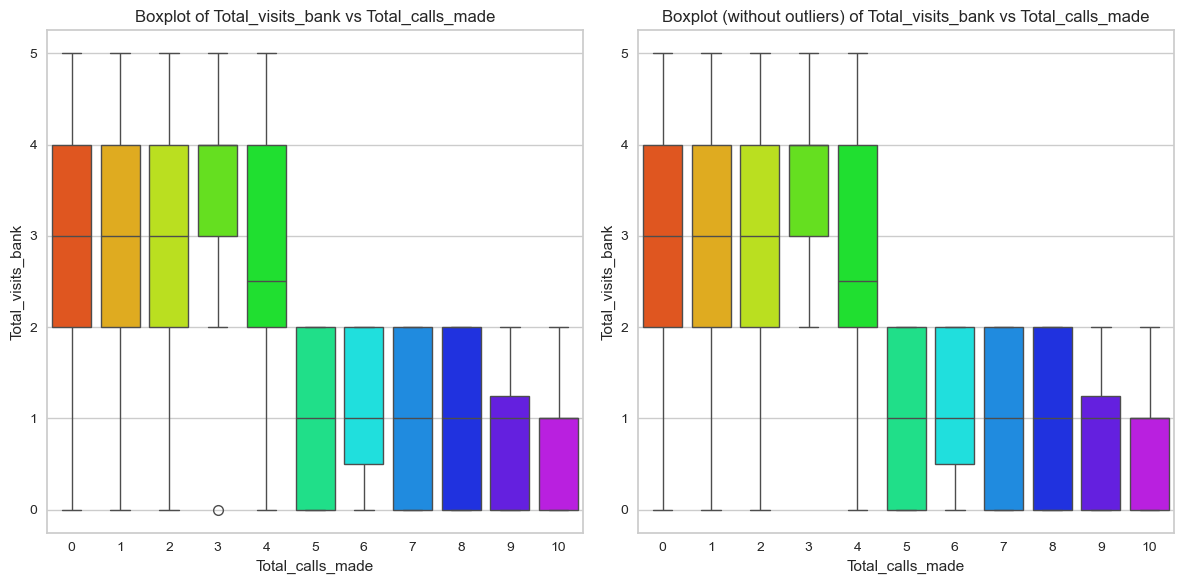

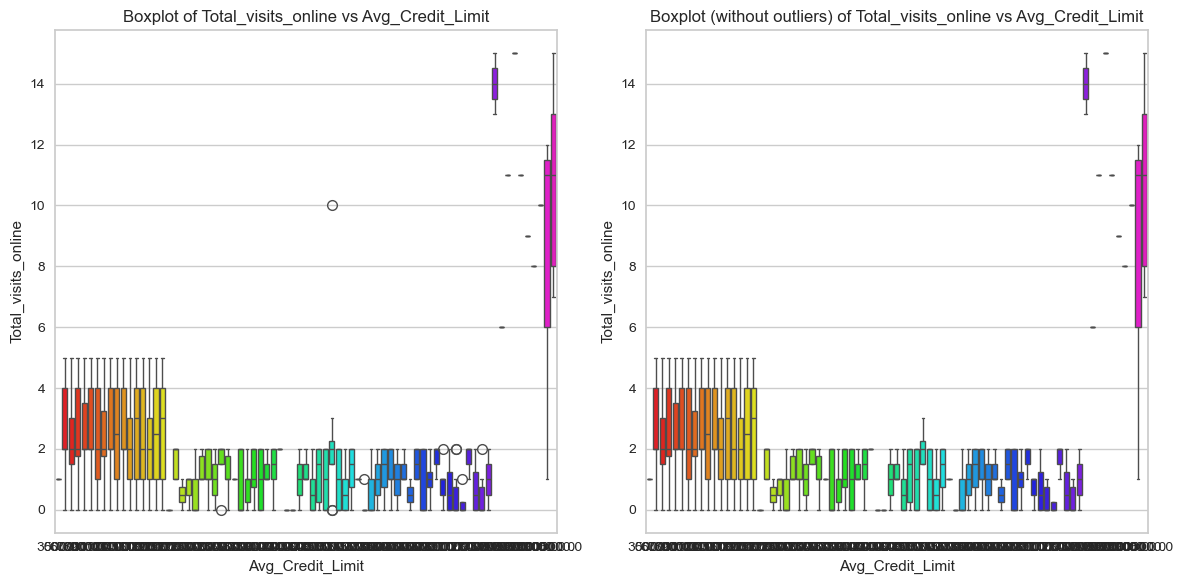

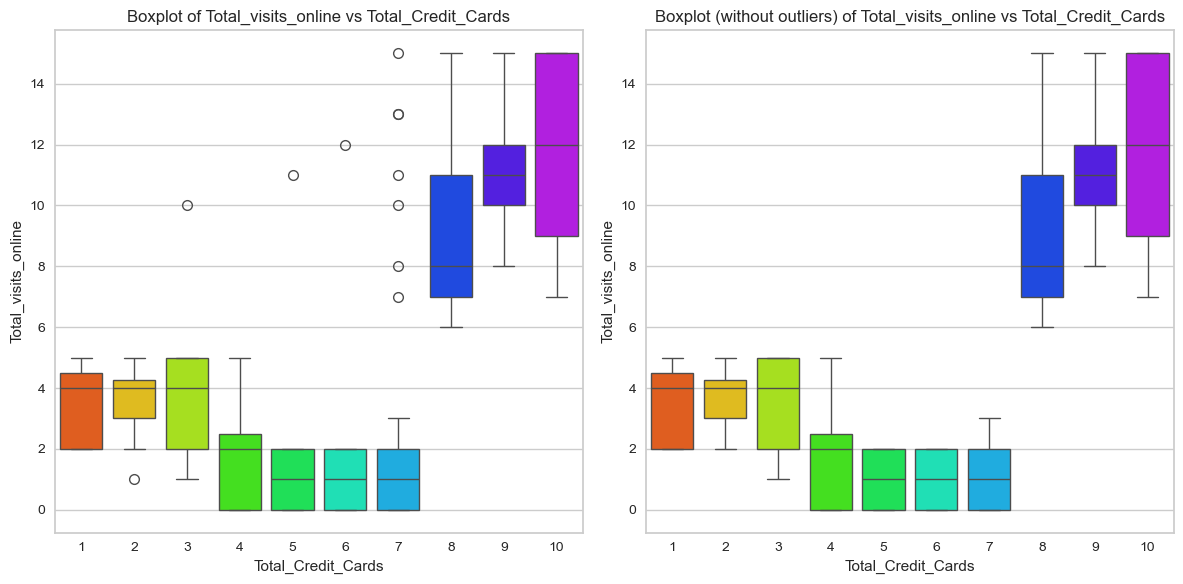

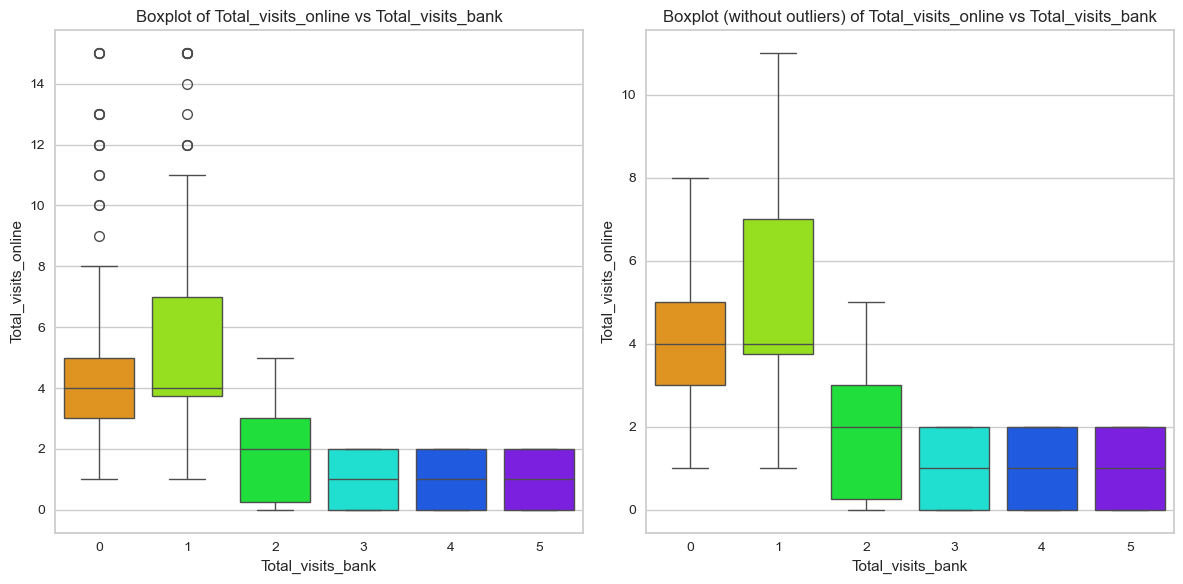

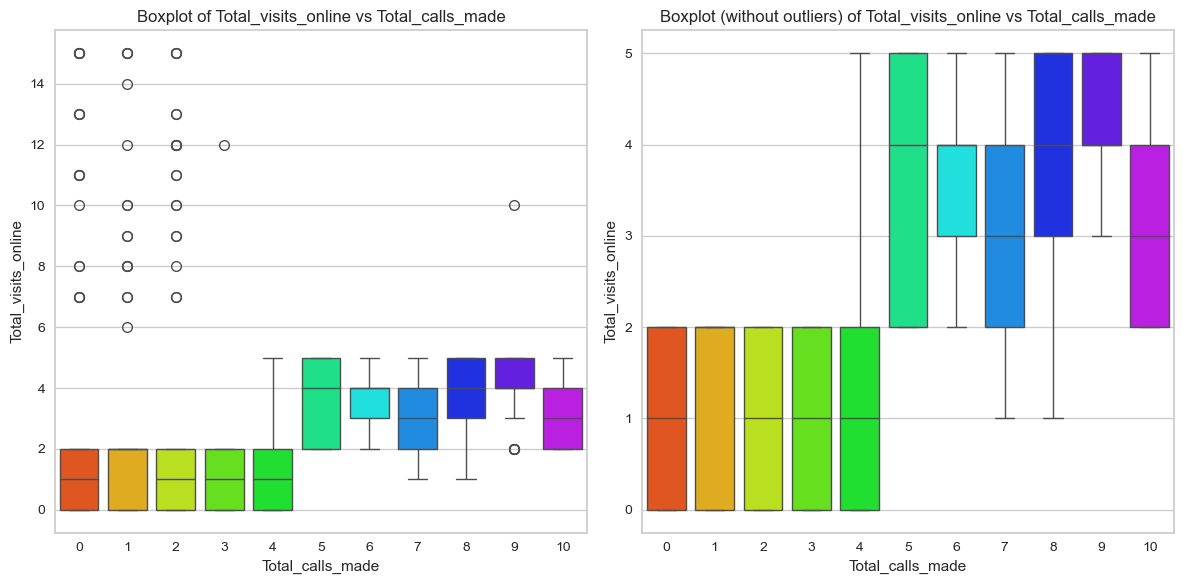

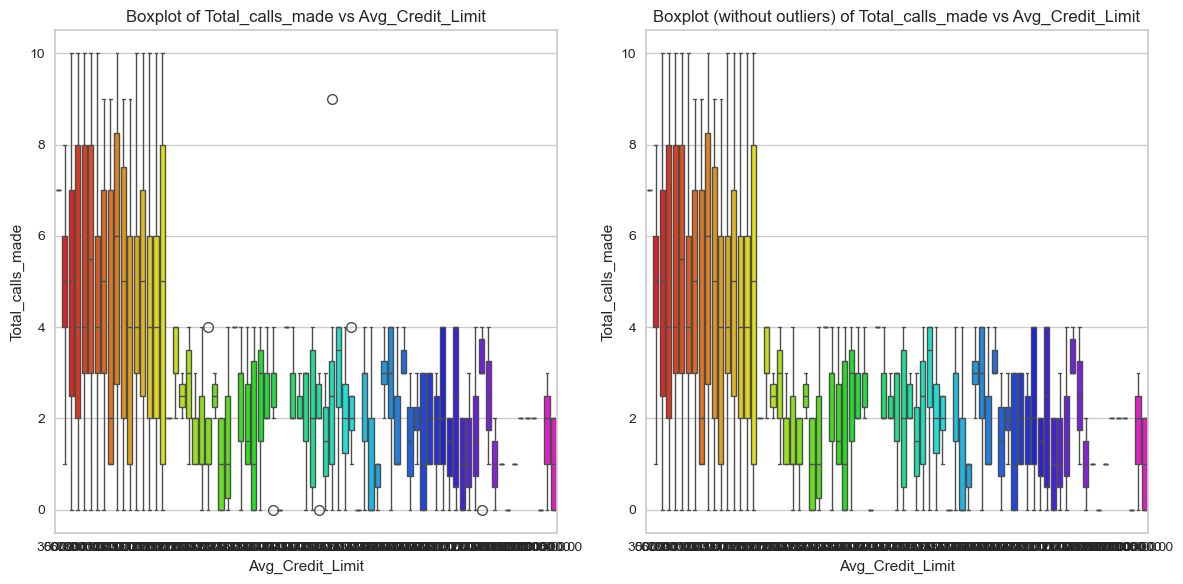

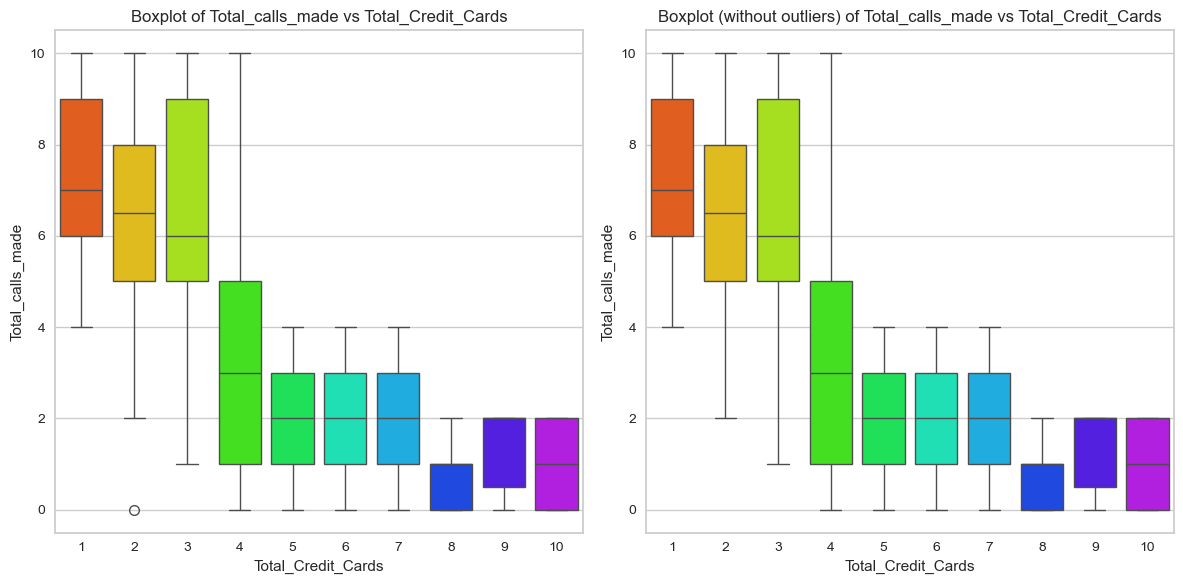

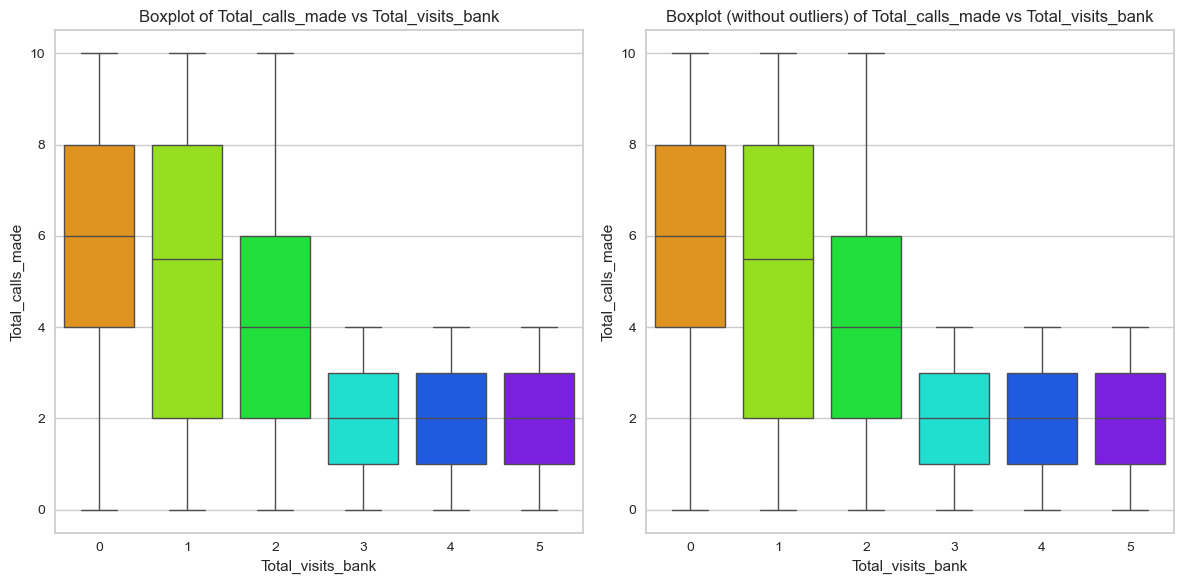

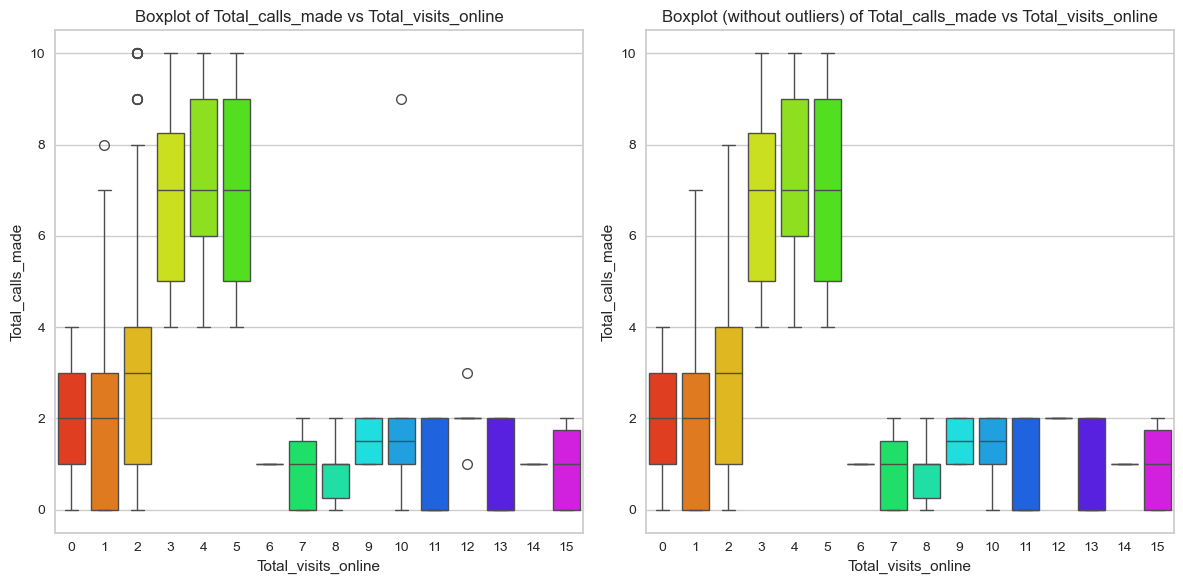

In [171]:
for col1 in df.columns:
    for col2 in df.columns:
        if col2 != col1:
            box_plot_two_variable(df, col1,col2)
            
    
        

Total_visits_bank    0    1    2    3   4   5  All
Avg_Credit_Limit                                  
All                100  112  158  100  92  98  660
14000.0              7    5    4    1   5   1   23
8000.0               9    4   10    5   5   2   35
13000.0              8   10    2    1   4   3   28
36000.0              0    0    3    2   4   2   11
...                ...  ...  ...  ...  ..  ..  ...
61000.0              0    0    1    1   0   1    3
63000.0              0    0    0    1   0   1    2
29000.0              0    0    1    2   0   2    5
65000.0              0    0    1    3   0   1    5
3000.0               1    0    0    0   0   0    1

[78 rows x 7 columns]
------------------------------------------------------------------------------------------------------------------------
Total_visits_bank     0    1    2    3   4   5  All
Total_Credit_Cards                                 
All                 100  112  158  100  92  98  660
4                    13   22   35   2

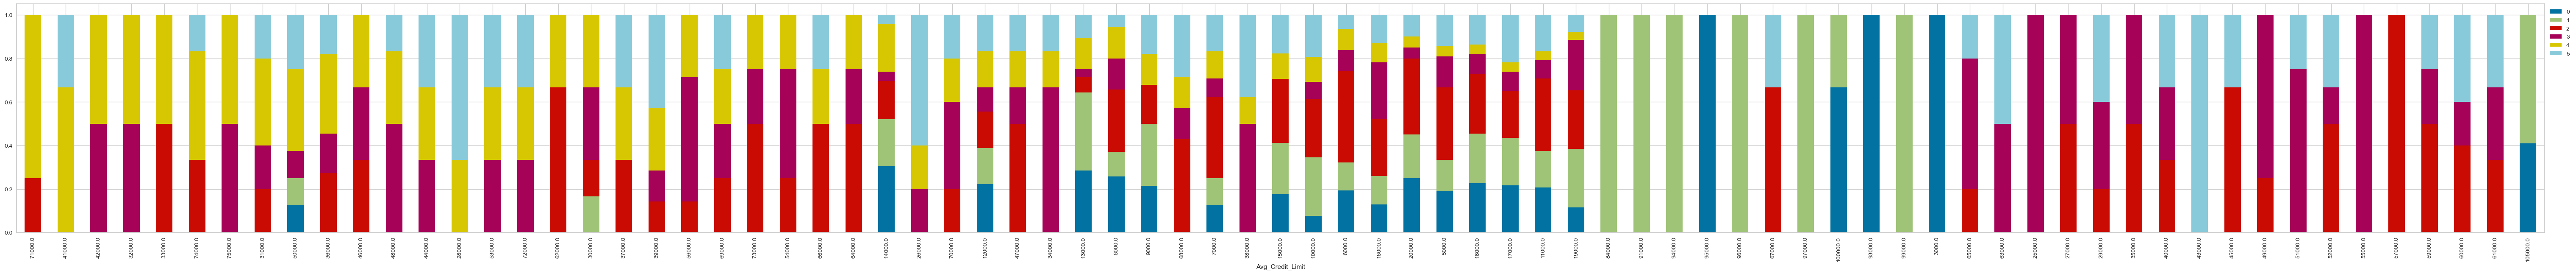

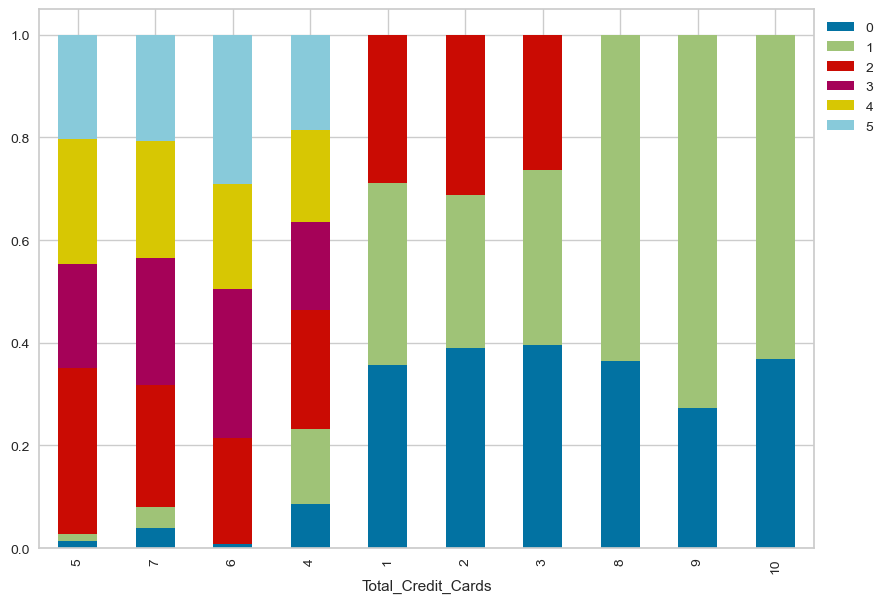

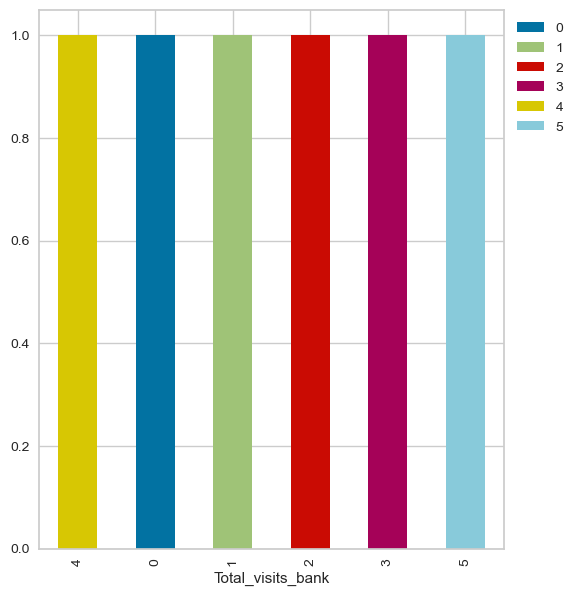

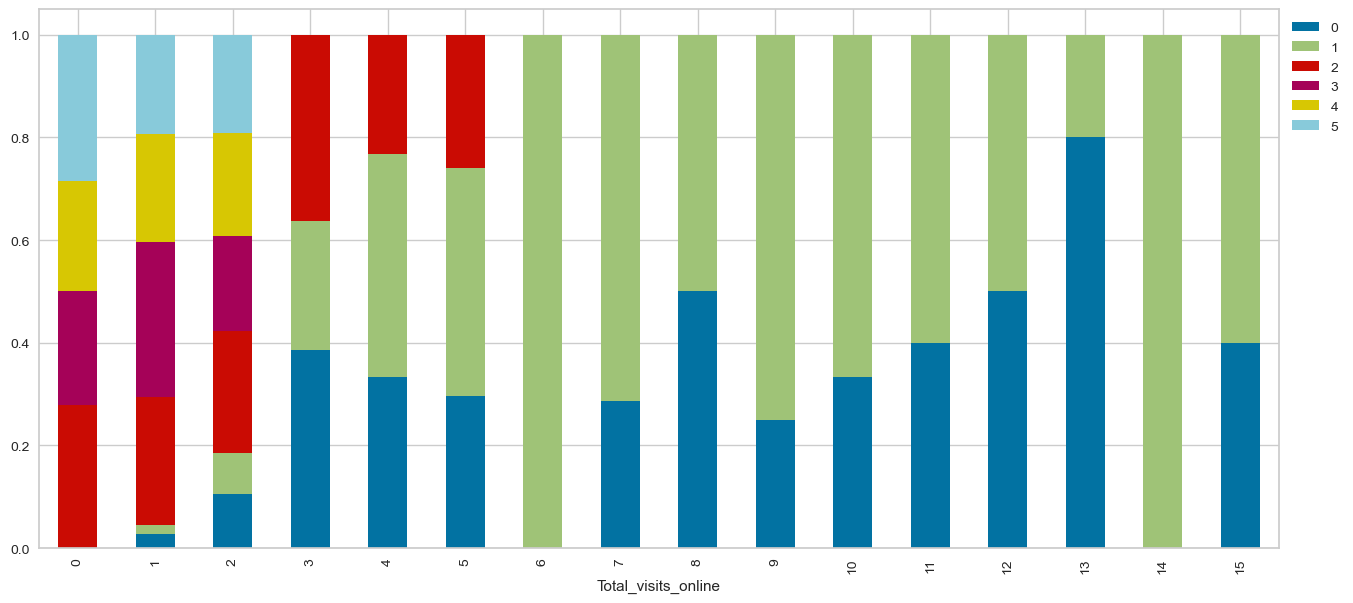

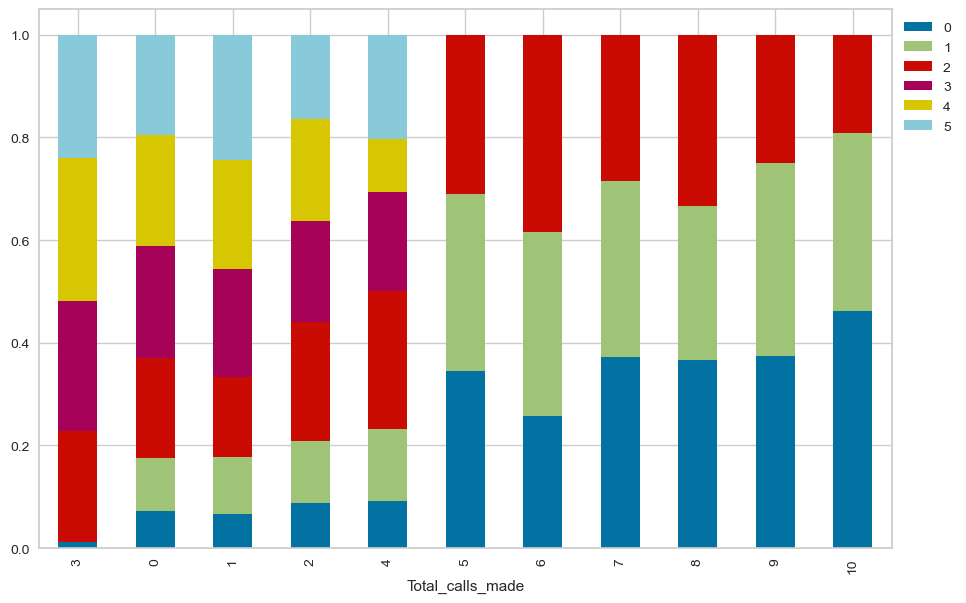

In [172]:
for col in df.columns:
    stacked_barplot(df,col,'Total_visits_bank')

## Data Scaling


Scaling is very important before clustering.

In [175]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled.iloc[:, :] = scaler.fit_transform(df_scaled.iloc[:, :])
df_scaled.head()


Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0          2.398942           -1.249225          -0.860451   
1          0.643619           -0.787585          -1.473731   
2          0.643619            1.058973          -0.860451   
3         -0.058511            0.135694          -0.860451   
4          2.398942            0.597334          -1.473731   

   Total_visits_online  Total_calls_made  
0            -0.547490         -1.251537  
1             2.520519          1.891859  
2             0.134290          0.145528  
3            -0.547490          0.145528  
4             3.202298         -0.203739

# **Model Building**

## K-means Clustering

### Checking Elbow Plot

Number of Clusters: 2 	Average Distortion: 1.755501055389377
Number of Clusters: 3 	Average Distortion: 1.1836293794561177
Number of Clusters: 4 	Average Distortion: 1.0700524605928141
Number of Clusters: 5 	Average Distortion: 1.0024110842154574
Number of Clusters: 6 	Average Distortion: 0.9642295040919028
Number of Clusters: 7 	Average Distortion: 0.9092212293058839
Number of Clusters: 8 	Average Distortion: 0.8832543493966902
Number of Clusters: 9 	Average Distortion: 0.8645268683858071
Number of Clusters: 10 	Average Distortion: 0.8419992835184149


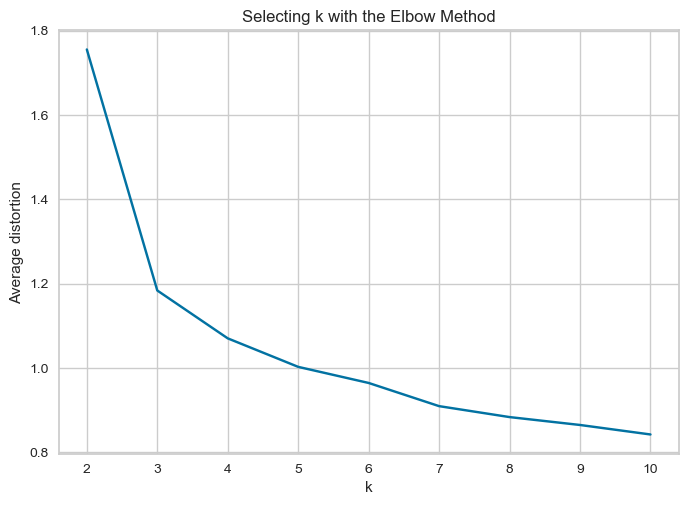

In [179]:
clusters = range(2,11)
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
distortions = []
for k in clusters:
    model = KMeans(n_clusters=k,random_state=1)
    kmeans= model.fit(df_scaled)
    distortion = sum(np.min(cdist(df_scaled,model.cluster_centers_,'euclidean'),axis=1))/df_scaled.shape[0]
    distortions.append(distortion)
    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters,distortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.savefig(f'D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/elbow.jpg',dpi=100)
plt.show()


**Let's do further analysis to determine the optimal value of k**

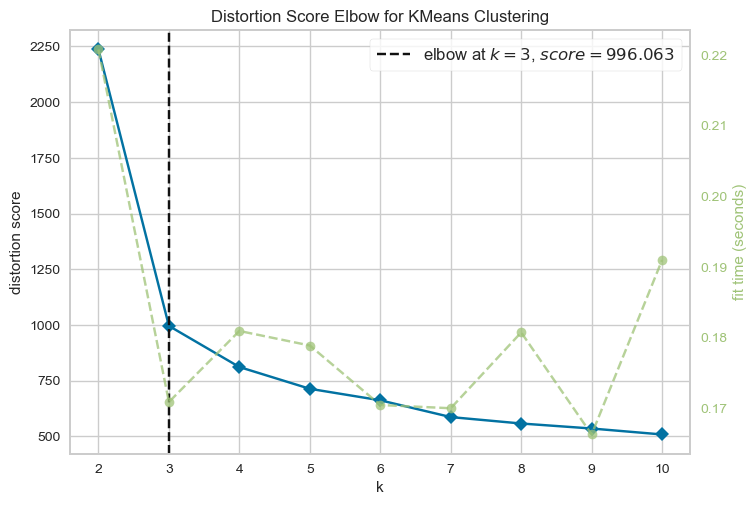

In [181]:
from yellowbrick.cluster import KElbowVisualizer
model=KMeans(random_state=1)
visualizer = KElbowVisualizer(model,k=(2,11),timing=True)
visualizer.fit(df_scaled)
figure = visualizer.fig;
visualizer.show()
figure.savefig(f'D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/distortion_score.jpg',dpi=100)
plt.close(figure)


#### Let's check the silhouette scores

For n_clusters = 2, the silhouette score is 0.4138293431016039)
For n_clusters = 3, the silhouette score is 0.5075309885053054)
For n_clusters = 4, the silhouette score is 0.37980395444812504)
For n_clusters = 5, the silhouette score is 0.3498370635383446)
For n_clusters = 6, the silhouette score is 0.27220958947721213)
For n_clusters = 7, the silhouette score is 0.26456292258119385)
For n_clusters = 8, the silhouette score is 0.2575123443993521)
For n_clusters = 9, the silhouette score is 0.23755436819502862)
For n_clusters = 10, the silhouette score is 0.23309787384423367)


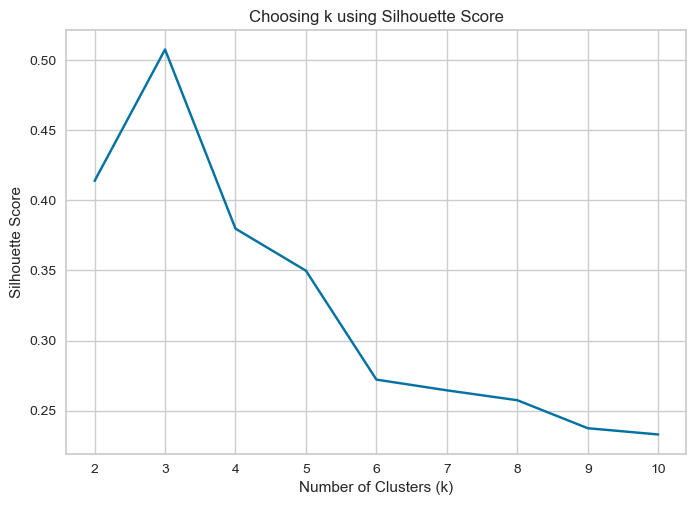

In [183]:
from sklearn.metrics import silhouette_score
sil_score=[]
clusters = range(2,11)
for k in clusters:
    model = KMeans(n_clusters=k)
    pred = model.fit_predict(df_scaled)
    score=silhouette_score(df_scaled,pred)
    sil_score.append(score)
    print(f"For n_clusters = {k}, the silhouette score is {score})")
plt.plot(clusters,sil_score)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Choosing k using Silhouette Score")

plt.savefig(f'D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/silhouette.jpg',dpi=100)
plt.show()
    

**Silhouette score for 3 is greater than other k values. So, we will choose 3 as value of k.**

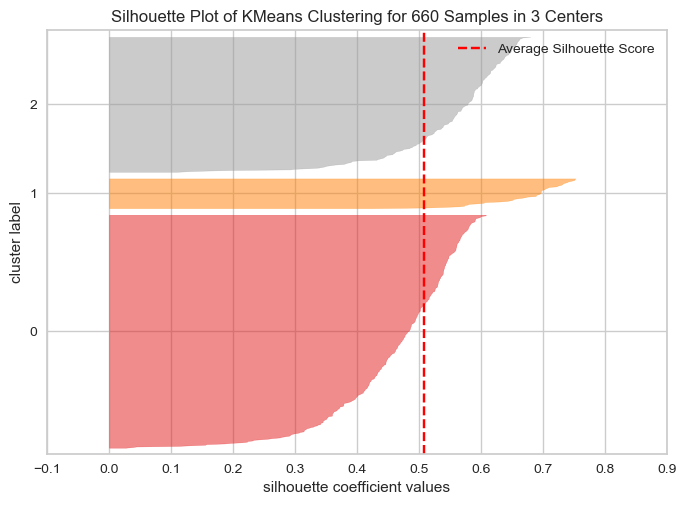

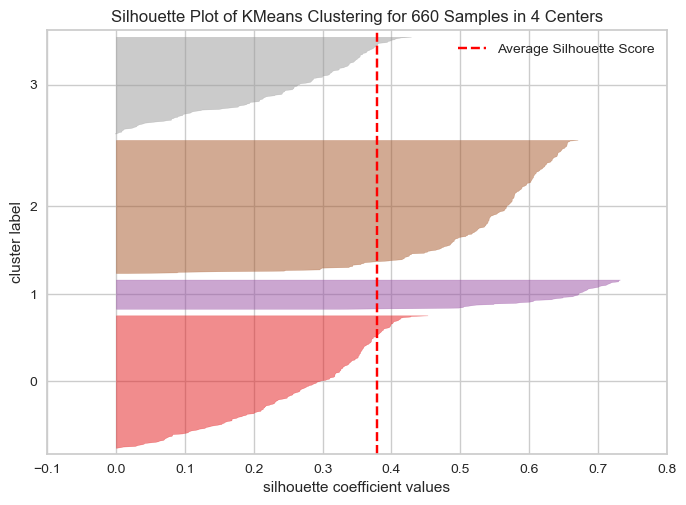

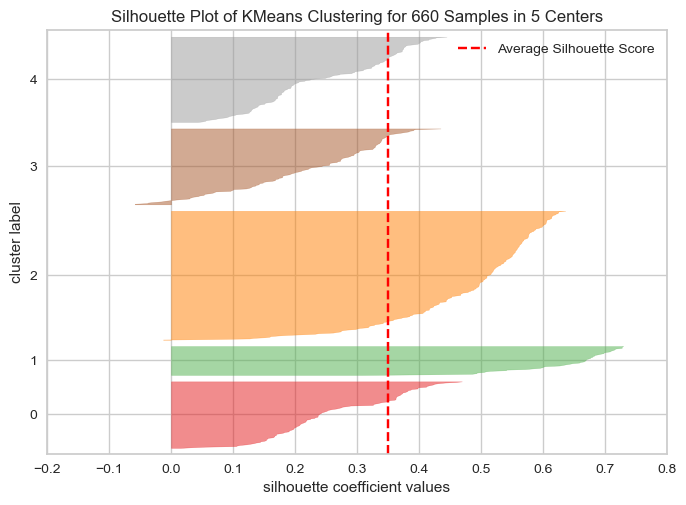

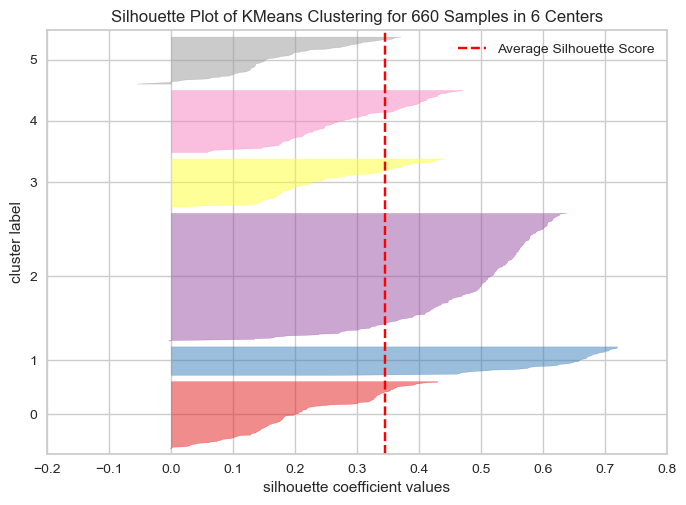

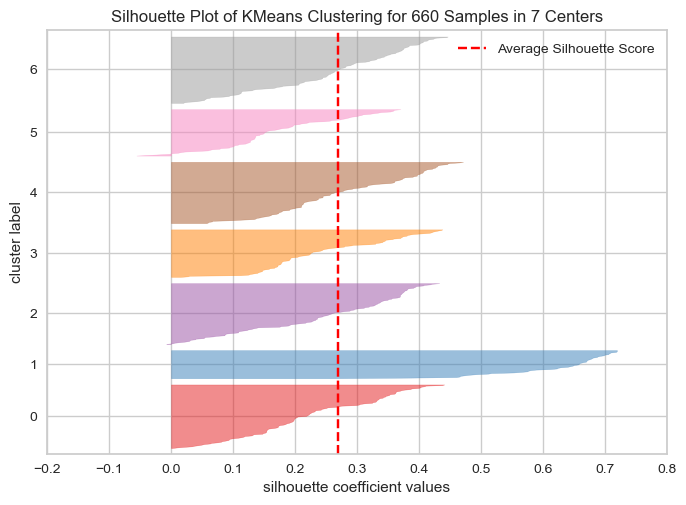

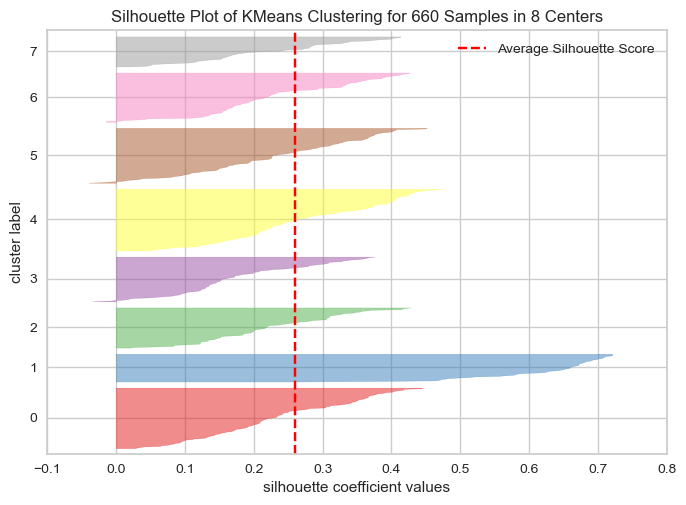

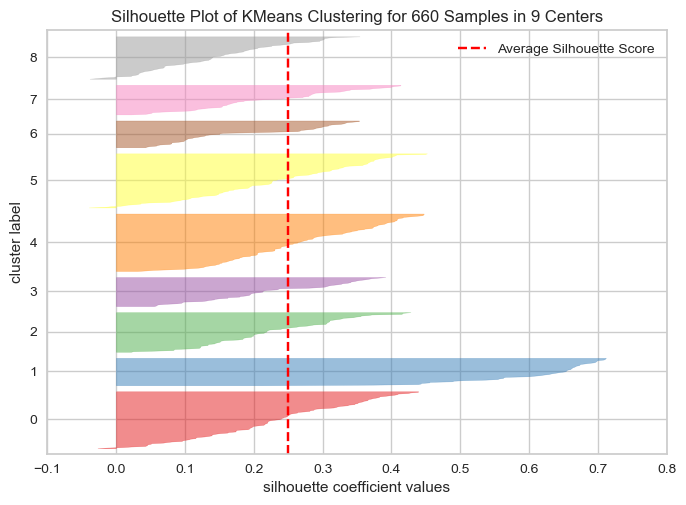

In [185]:
#To visualize the elbow curve and silhouette score 
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
for k in [3,4,5,6,7,8,9]:
    visualizer= SilhouetteVisualizer(KMeans(n_clusters=k,random_state=1))
    visualizer.fit(df_scaled)
    figure = visualizer.fig
    visualizer.show()
    figure.savefig(f'D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/7_{k}_visualizer.jpg',dpi=100)
    plt.close(figure)


**Final Model**

In [187]:

from sklearn.cluster import KMeans
kmeans =  KMeans(3,random_state=1)
kmeans.fit(df_scaled)
df['KMeans_group']=kmeans.labels_
df_scaled['KMeans_group']=kmeans.labels_

In [188]:
df

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            100000.0                   2                  1   
1             50000.0                   3                  0   
2             50000.0                   7                  1   
3             30000.0                   5                  1   
4            100000.0                   6                  0   
..                ...                 ...                ...   
655           99000.0                  10                  1   
656           84000.0                  10                  1   
657          105000.0                   8                  1   
658          105000.0                  10                  1   
659          105000.0                   9                  0   

     Total_visits_online  Total_calls_made  KMeans_group  
0                      1                 0             0  
1                     10                 9             2  
2                      3                 4             0  
3                      1                 4             0  
4                     12                 3             1  
..                   ...               ...           ...  
655                   10                 0             1  
656                   13                 2             1  
657                    9                 1             1  
658                   15                 0             1  
659                   12                 2             1  

[660 rows x 6 columns]

## Cluster Profiling

In [190]:
cluster_profile = df.groupby('KMeans_group')[df.columns].mean(numeric_only=True)
# displaying the group-wise means of variables
cluster_profile



Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
KMeans_group                                                            
0                 33782.383420            5.515544           3.489637   
1                102660.000000            8.740000           0.600000   
2                 12174.107143            2.410714           0.933036   

              Total_visits_online  Total_calls_made  KMeans_group  
KMeans_group                                                       
0                        0.981865          2.000000           0.0  
1                       10.900000          1.080000           1.0  
2                        3.553571          6.870536           2.0

In [191]:
cluster_profile['count']=df['KMeans_group'].value_counts()
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

In [192]:
pd.crosstab(df.KMeans_group,df.Total_visits_online).style.highlight_max(color="lightgreen", axis=0)

In [193]:
for i in df.columns[1:7]:
    print(pd.crosstab(df.KMeans_group,df[i]))

Total_Credit_Cards  1   2   3    4   5    6   7   8   9   10
KMeans_group                                                
0                    0   1   0  102  73  116  94   0   0   0
1                    0   0   0    0   1    1   7  11  11  19
2                   59  63  53   49   0    0   0   0   0   0
Total_visits_bank   0   1   2    3   4   5
KMeans_group                              
0                   0   3  93  100  92  98
1                  20  30   0    0   0   0
2                  80  79  65    0   0   0
Total_visits_online   0    1    2   3   4   5   6   7   8   9   10  11  12  \
KMeans_group                                                                 
0                    144  106  135   1   0   0   0   0   0   0   0   0   0   
1                      0    0    0   0   0   0   1   7   6   4   5   5   6   
2                      0    3   54  43  69  54   0   0   0   0   1   0   0   

Total_visits_online  13  14  15  
KMeans_group                     
0                    

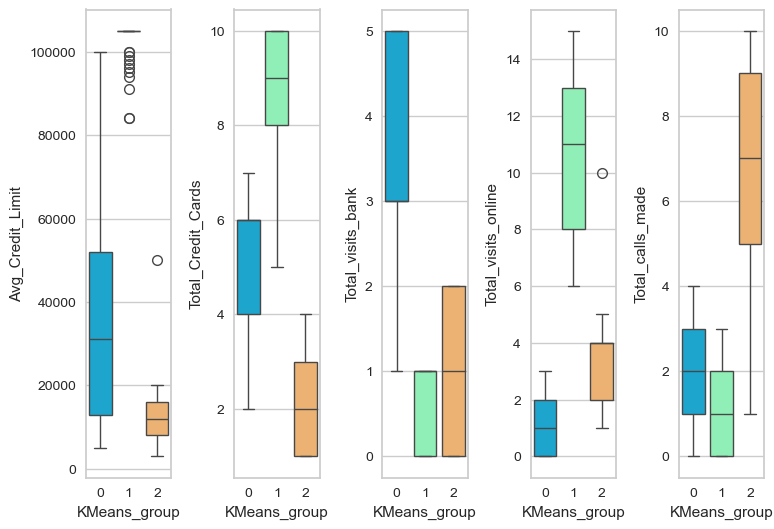

In [194]:


for i,col in enumerate(df.columns[:5]):
    plt.subplot(1,5,i+1)
    plt.tight_layout()  # Prevent padding issues
    sns.boxplot(x=df['KMeans_group'],y=df[f"{col}"],palette='rainbow')
plt.savefig(f'D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/8_Cluster_profiling.jpg',dpi=100)

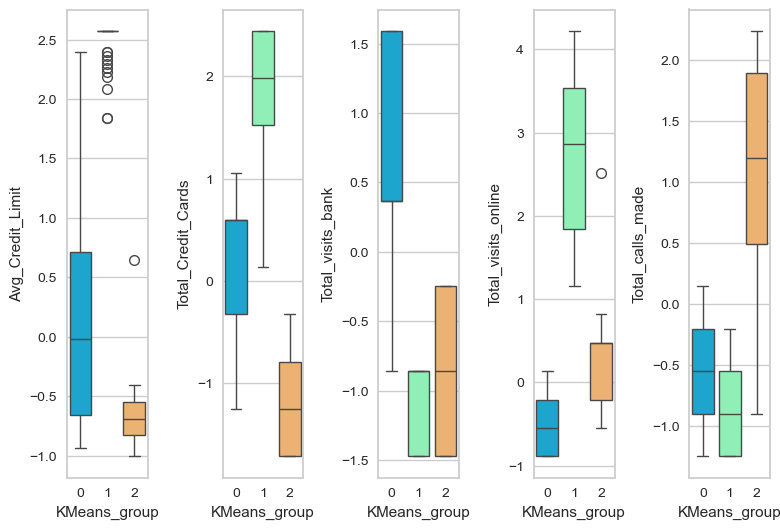

In [195]:


for i,col in enumerate(df.columns[:5]):
    # print(i)
    plt.subplot(1,5,i+1)
    plt.tight_layout()  # Prevent padding issues
    sns.boxplot(x=df_scaled['KMeans_group'],y=df_scaled[f"{col}"],palette='rainbow')
plt.savefig(f'D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/8_scaled_Cluster_profiling.jpg',dpi=100)

<Figure size 2000x2600 with 0 Axes>

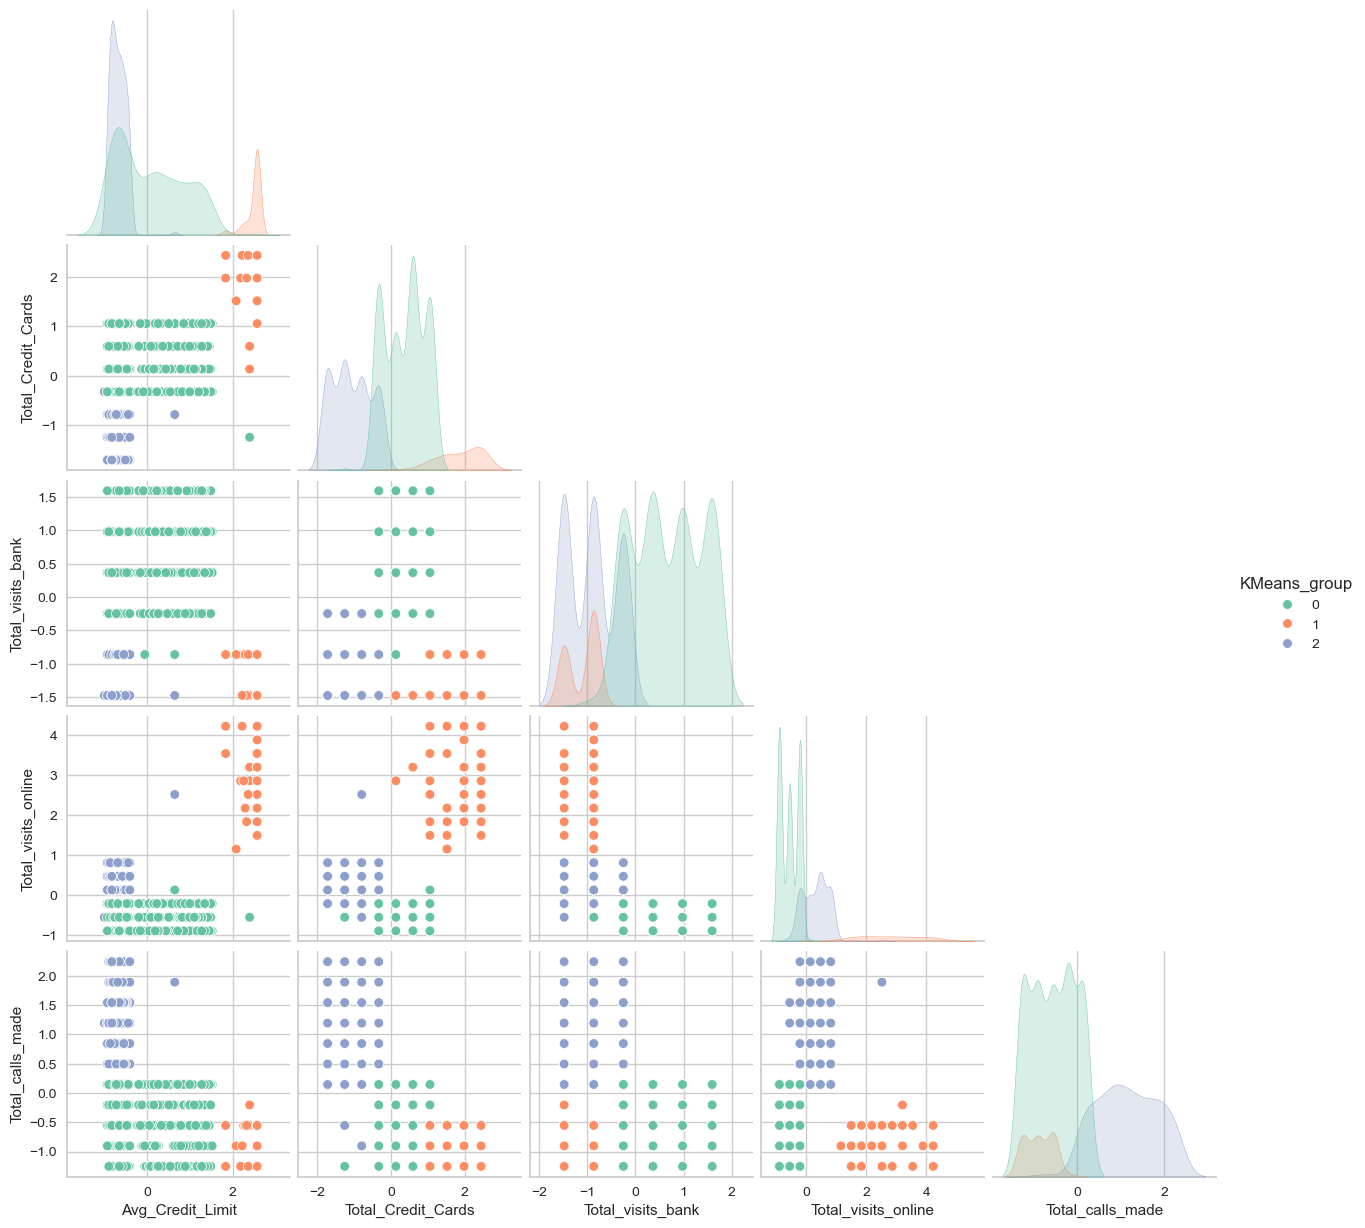

In [196]:
plt.figure(figsize=(20, 26))

sns.pairplot(df_scaled[:][:-1], diag_kind='kde', corner=True, hue='KMeans_group', palette='Set2');
plt.savefig(f'D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/pairplot2.jpg',dpi=100)

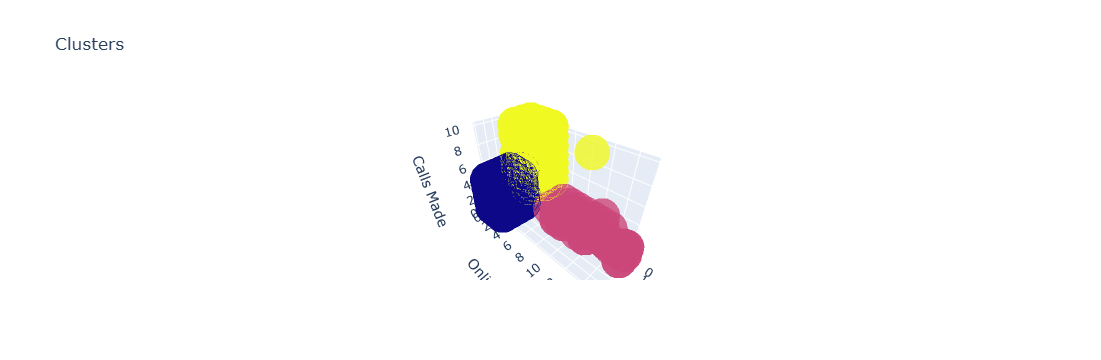

In [197]:
import plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x= data['Total_visits_bank'],
    y= data['Total_visits_online'],
    z= data['Total_calls_made'],
    mode='markers',
     marker=dict(
        color = df['KMeans_group'], 
        size= 20,
        line=dict(
            color= df['KMeans_group'],
            width= 12
        ),
        opacity=0.8
     ),

)
d = [trace1]
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Bank Visits'),
            yaxis = dict(title  = 'Online'),
            zaxis = dict(title  = 'Calls Made')
        )
)
fig = go.Figure(data=d, layout=layout)

# Save the figure
pio.write_image(fig, "D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/3d.jpg", scale=2)
py.offline.iplot(fig)

## Hierarchical Clustering


### Computing Cophenetic Correlation

In [200]:
from scipy.cluster.hierarchy import linkage,cophenet
from scipy.spatial.distance import cdist,pdist
# list of distance metrics
distance_metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
        'cosine', 'euclidean', 'hamming', 'jaccard', 'mahalanobis', 'matching', 'minkowski', 'seuclidean',  'sqeuclidean']

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z= linkage(df_scaled,metric=dm,method=lm)
        c,coph_dists= cophenet(Z,pdist(df_scaled))
        print(f"Cophenetic correlation for {dm.capitalize()} distance and {lm} linkage is {c}.")
        if c> high_cophenet_corr:
            high_cophenet_corr=c
            high_dm_lm[0] = dm
            high_dm_lm[1]=lm
            
print(
    f"Highest cophenetic correlation is {high_cophenet_corr}, which is obtained with {high_dm_lm[0].capitalize()} distance and {high_dm_lm[1]} linkage.")


Cophenetic correlation for Braycurtis distance and single linkage is 0.8375544614800204.
Cophenetic correlation for Braycurtis distance and complete linkage is 0.5267857784120373.
Cophenetic correlation for Braycurtis distance and average linkage is 0.7880599893601058.
Cophenetic correlation for Braycurtis distance and weighted linkage is 0.6934546603183509.
Cophenetic correlation for Canberra distance and single linkage is 0.880520623317417.
Cophenetic correlation for Canberra distance and complete linkage is 0.7135324030750694.
Cophenetic correlation for Canberra distance and average linkage is 0.8158829456697183.
Cophenetic correlation for Canberra distance and weighted linkage is 0.7381468205101213.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7853902350966868.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8318695955800918.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9101241814670633.
Cophenetic correlati

### Checking Dendrograms

**We see that the cophenetic correlation is maximum with Euclidean distance and average linkage.**


**Let's view the dendrograms for the different linkage methods.**

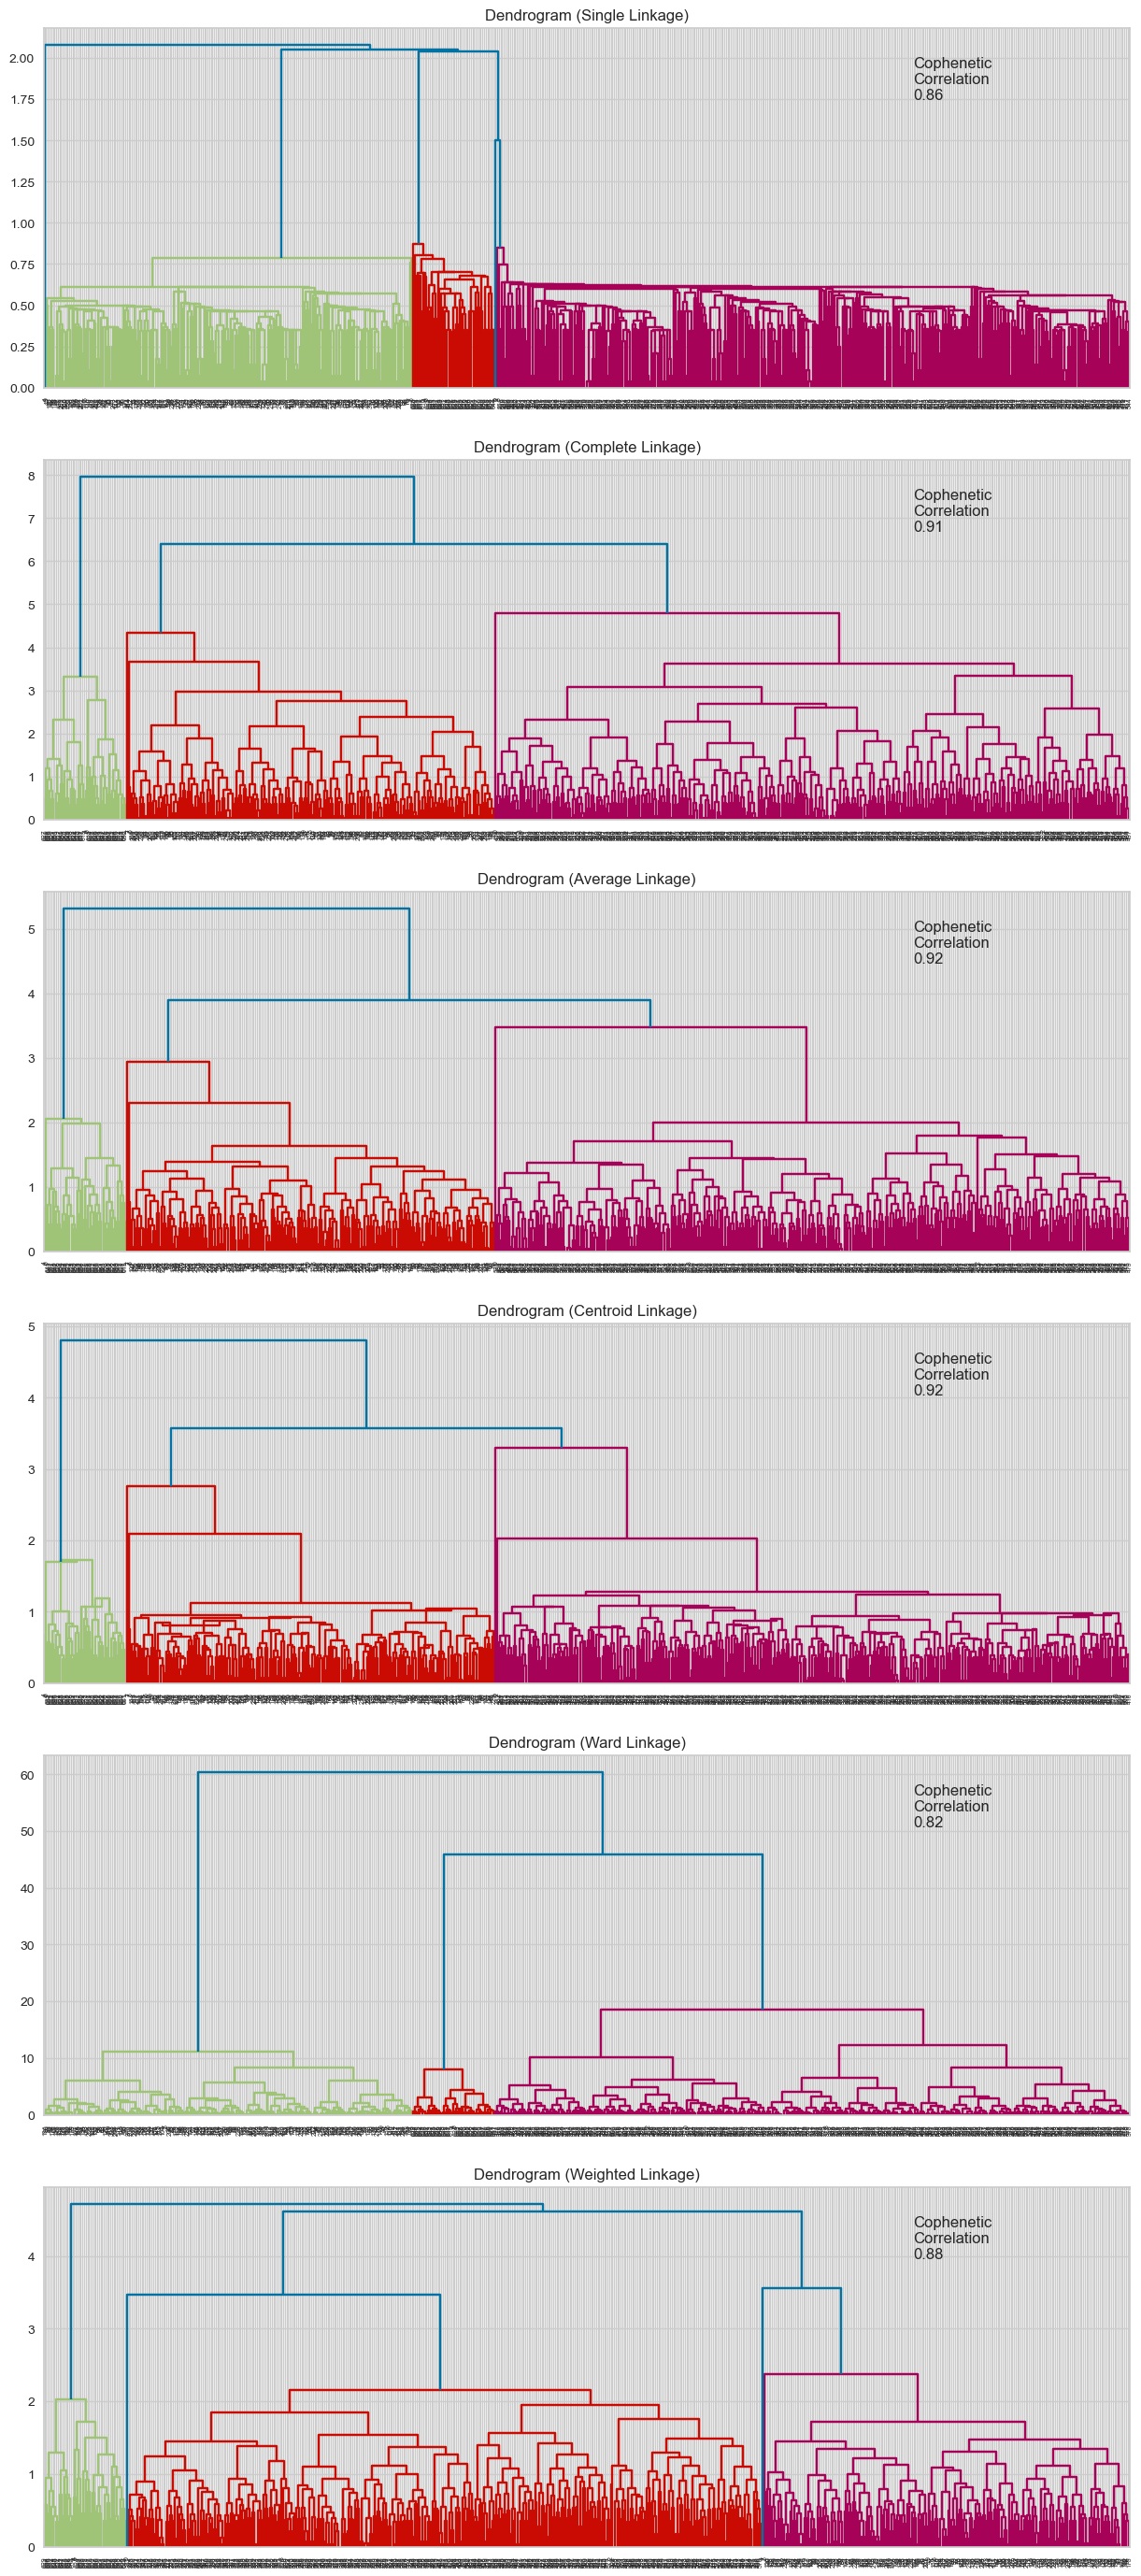

In [203]:
from scipy.cluster.hierarchy import cophenet,dendrogram,linkage
linkage_methods =  ['single','complete','average','centroid','ward','weighted']
# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare=[]
fig,axs = plt.subplots(len(linkage_methods),1,figsize=(15,35))
for i,method in enumerate(linkage_methods):
    Z=linkage(df_scaled,metric='euclidean',method=method)
    dendrogram(Z,ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")
    coph_corr,coph_dist= cophenet(Z,pdist(df_scaled))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])
    plt.savefig(f'D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/dendrogram_{method}.jpg',dpi=100)
    

**Observations**

- Looking the the above dendrograms, the Average linkage seems to result in the best separation between clusters, even though its cophenetic correlation is lower than the other linkages.
- 3 looks to be a good choice for no. of clusters.

### Creating Final Model

In [206]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters=3,linkage='average')
# The 'affinity' parameter has been removed in scikit-learn 1.2 and later.
# When using 'ward' linkage, the distance metric must be 'euclidean' by default.
# There's no need to specify 'metric' explicitly.
df['Hierarchical_group'] = hc.fit_predict(df_scaled)
df_scaled['Hierarchical_group'] = hc.fit_predict(df_scaled)

## Cluster Profiling: Hierarchical Clustering

In [208]:
df.columns

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made', 'KMeans_group',
       'Hierarchical_group'],
      dtype='object')

In [209]:
cluster_profile = df.groupby('Hierarchical_group')[df.columns].mean(numeric_only=True)
# displaying the group-wise means of variables
cluster_profile



Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
KMeans_group                                                            
0                 33782.383420            5.515544           3.489637   
1                102660.000000            8.740000           0.600000   
2                 12174.107143            2.410714           0.933036   

              Total_visits_online  Total_calls_made  KMeans_group  \
KMeans_group                                                        
0                        0.981865          2.000000           0.0   
1                       10.900000          1.080000           1.0   
2                        3.553571          6.870536           2.0   

              Hierarchical_group  
KMeans_group                      
0                            0.0  
1                            1.0  
2                            2.0

In [210]:
cluster_profile['count']=df['Hierarchical_group'].value_counts()
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

In [211]:
pd.crosstab(df.Hierarchical_group,df.Total_visits_online).style.highlight_max(color="lightgreen", axis=0)

In [ ]:
cluster_profile_hc = df.iloc[:,1:].groupby('hc_cluster').mean()
cluster_profile_hc['count_of_customers'] = data.groupby('hc_cluster')['customer_key'].count()

cluster_profile_hc.style.highlight_max(color='lightgreen').highlight_min(color='pink')

In [212]:
count = (df['KMeans_group'] != df['Hierarchical_group']).sum()
print(count)


0


In [213]:
count = (df['KMeans_group'] == df['Hierarchical_group']).sum()
print(count)


660


In [354]:
data['Hierarchical_group'] = df['Hierarchical_group']

In [360]:
data

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0        1         87073            100000                   2   
1        2         38414             50000                   3   
2        3         17341             50000                   7   
3        4         40496             30000                   5   
4        5         47437            100000                   6   
..     ...           ...               ...                 ...   
655    656         51108             99000                  10   
656    657         60732             84000                  10   
657    658         53834            145000                   8   
658    659         80655            172000                  10   
659    660         80150            167000                   9   

     Total_visits_bank  Total_visits_online  Total_calls_made  \
0                    1                    1                 0   
1                    0                   10                 9   
2                    1                    3                 4   
3                    1                    1                 4   
4                    0                   12                 3   
..                 ...                  ...               ...   
655                  1                   10                 0   
656                  1                   13                 2   
657                  1                    9                 1   
658                  1                   15                 0   
659                  0                   12                 2   

     Hierarchical_group  
0                     0  
1                     2  
2                     0  
3                     0  
4                     1  
..                  ...  
655                   1  
656                   1  
657                   1  
658                   1  
659                   1  

[660 rows x 8 columns]

In [366]:
cluster_profile_hc = df.iloc[:,1:].groupby('Hierarchical_group').mean()
cluster_profile_hc['count_of_customers'] = data.groupby('Hierarchical_group')['Customer Key'].count()

cluster_profile_hc.style.highlight_max(color='lightgreen').highlight_min(color='pink')

<Figure size 2000x2600 with 0 Axes>

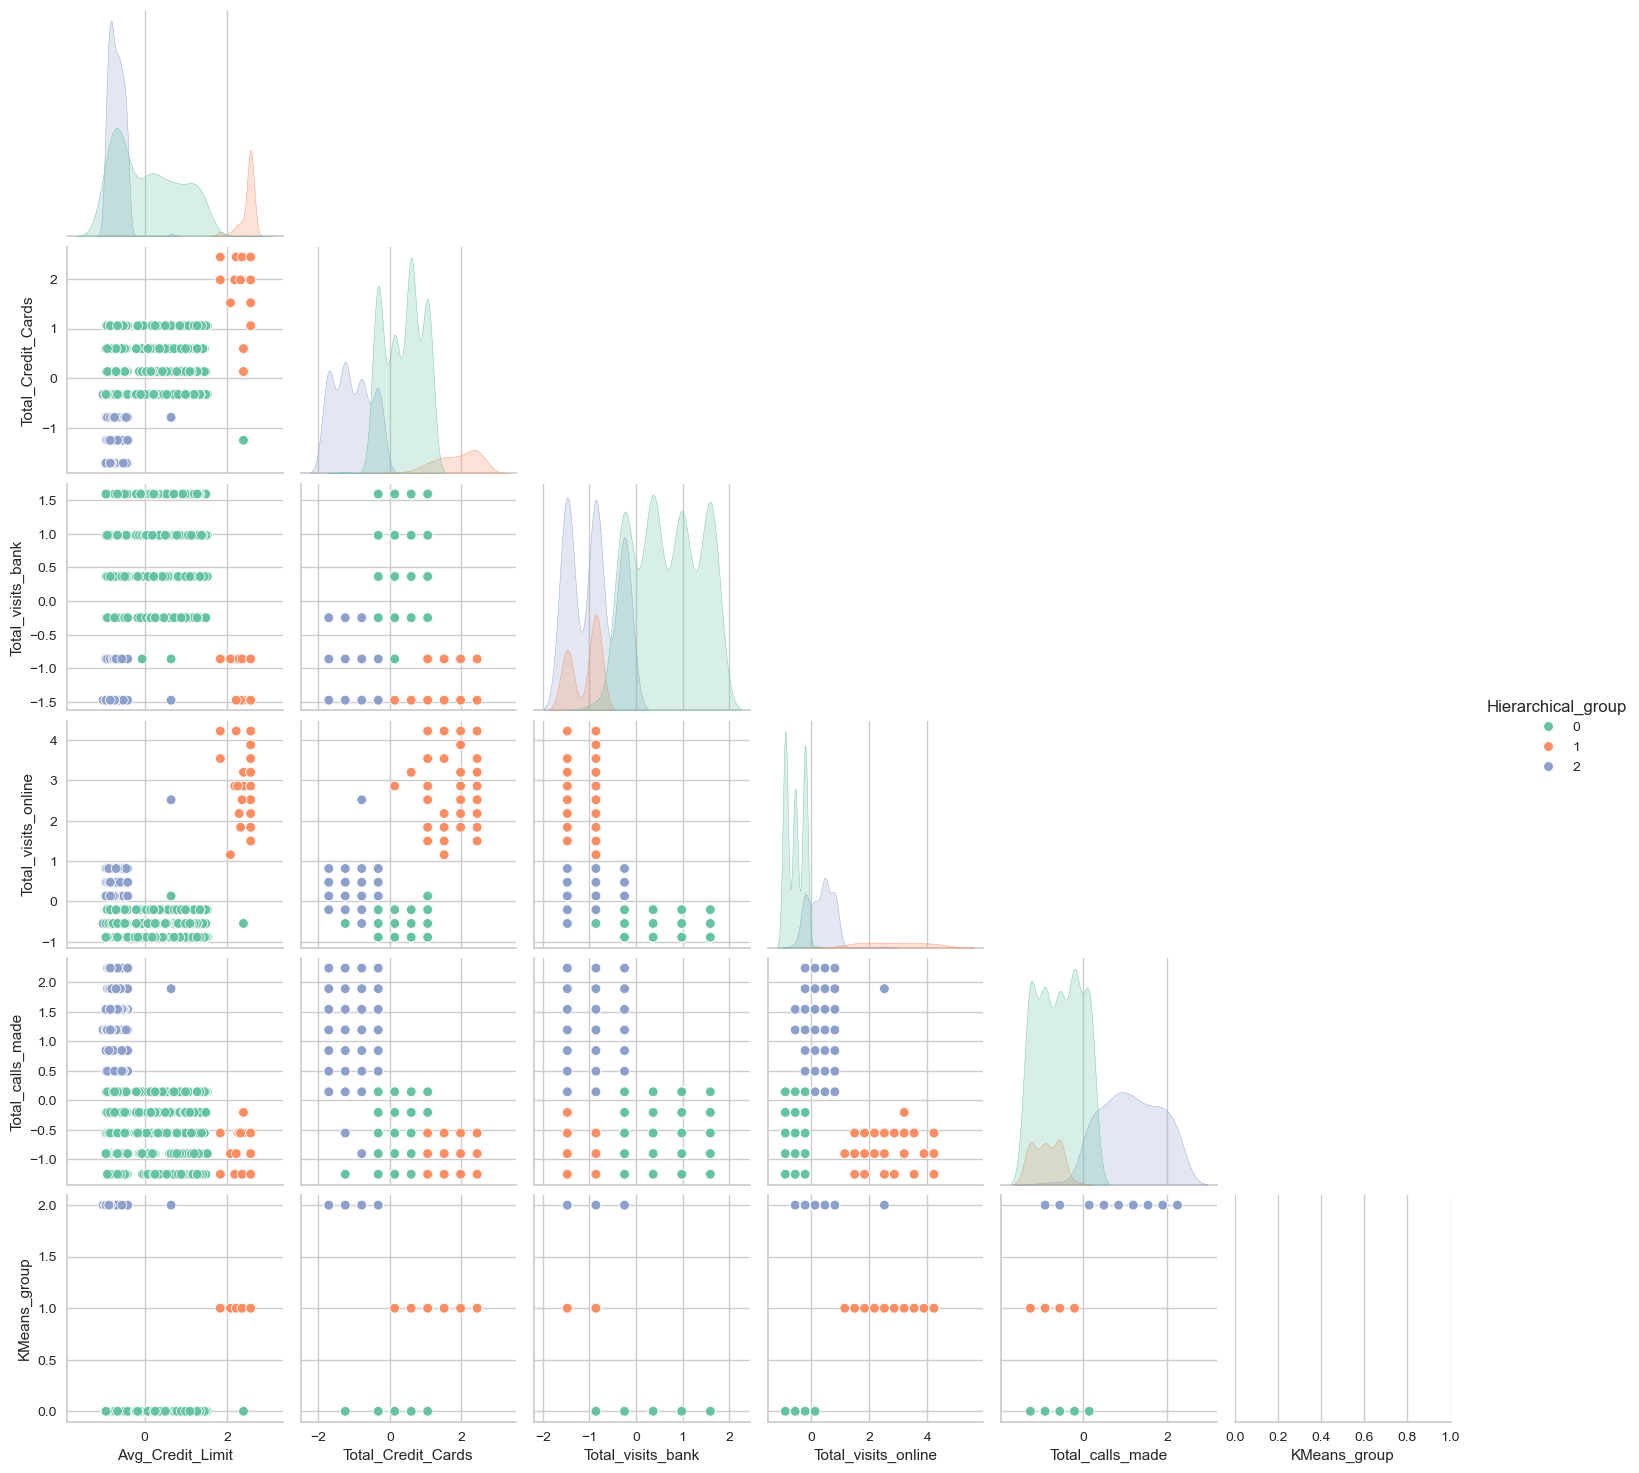

In [368]:
plt.figure(figsize=(20, 26))

sns.pairplot(df_scaled[:][:-1], diag_kind='kde', corner=True, hue='Hierarchical_group', palette='Set2');
plt.savefig(f'D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/pairplot3.jpg',dpi=100)

# **PCA for Visualization**

- Let's use PCA to reduce the data to two dimensions and visualize it to see how well-separated the clusters are.

In [216]:
covmatrix = np.cov(df_scaled.iloc[:,:-2],rowvar=False)
print(covmatrix)

[[ 1.00151745  0.61740584 -0.01719576  0.43257711 -0.45339031]
 [ 0.61740584  1.00151745  0.31627526  0.16801286 -0.65223974]
 [-0.01719576  0.31627526  1.00151745 -0.55269882 -0.50678371]
 [ 0.43257711  0.16801286 -0.55269882  1.00151745  0.12749255]
 [-0.45339031 -0.65223974 -0.50678371  0.12749255  1.00151745]]


Eigen Values:
 [3.77957988 1.90124379 0.33208971 0.31243381 0.28371041]
Eigen Vectors:
 [[-0.2165888  -0.37787563 -0.39119639  0.18601838  0.44169265  0.4623686
   0.4623686 ]
 [ 0.57570449  0.37713071 -0.32518818  0.61838124 -0.14210955  0.09486552
   0.09486552]
 [ 0.50422941 -0.4243117  -0.52105071 -0.49657115 -0.17497878 -0.09224411
  -0.09224411]
 [ 0.56135995 -0.0594997   0.44978562 -0.08823727  0.68623983 -0.01258524
  -0.01258524]
 [-0.16937766  0.63282797 -0.47008686 -0.33111273  0.45418194 -0.13027171
  -0.13027171]]
Percentage of variance explained by each eigen vector:
 [0.56091846 0.28215907 0.04928464 0.04636756 0.04210479]


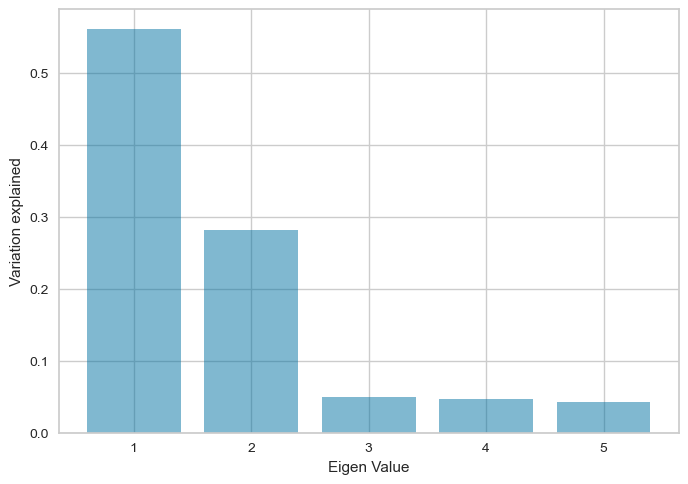

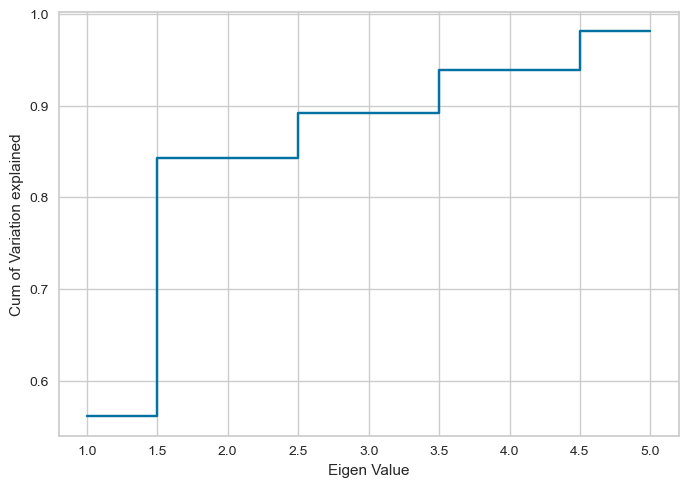

In [217]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit_transform(df_scaled)
print(f'Eigen Values:\n',pca.explained_variance_)
print(f'Eigen Vectors:\n',pca.components_)
print(f'Percentage of variance explained by each eigen vector:\n',pca.explained_variance_ratio_)
plt.bar(list(range(1, 6)), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')

# Save the figure before showing it
plt.savefig('D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/pca_1.jpg', dpi=100)

# Show the figure
plt.show()

# Close the figure to free memory
plt.close()

plt.step(list(range(1, 6)), np.cumsum(pca.explained_variance_ratio_),where='mid')
plt.ylabel('Cum of Variation explained')
plt.xlabel('Eigen Value')

# Save the figure before showing it
plt.savefig('D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/pca_2.jpg', dpi=100)

# Show the figure
plt.show()

# Close the figure to free memory
plt.close()

## Visualizing the data in the lower dimension

- We can visualize data in 2 dimensions and also data in 3 dimensions (using 3-D plots).
- In some cases, we can also visualize data in 4 dimensions by using different hues for the 4th dimension in a 3-D plot.
- But it's impossible for us to visualize and interpret data in 5 dimensions.
- So using PCA, we scaled down to 2 dimensions, and now it's easy for us to visualize the data.

In [220]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame(
    data=pca_data, columns=["Principal Component 1", "Principal Component 2"]
)
pca_df.head()

Principal Component 1  Principal Component 2
0              -1.063321               0.885906
1               3.190928               2.078843
2              -0.811453               0.968915
3              -0.437318              -0.205101
4               0.563894               4.141359

In [221]:
print(
    "Explained variance per principal component: {}".format(
        pca.explained_variance_ratio_
    )
)

Explained variance per principal component: [0.56091846 0.28215907]


In the above result, the explained variance is shown.

- The first principal component explains 56.1% of total variance in the data.
- The second principal component explains 28.2% of total variance in the data.

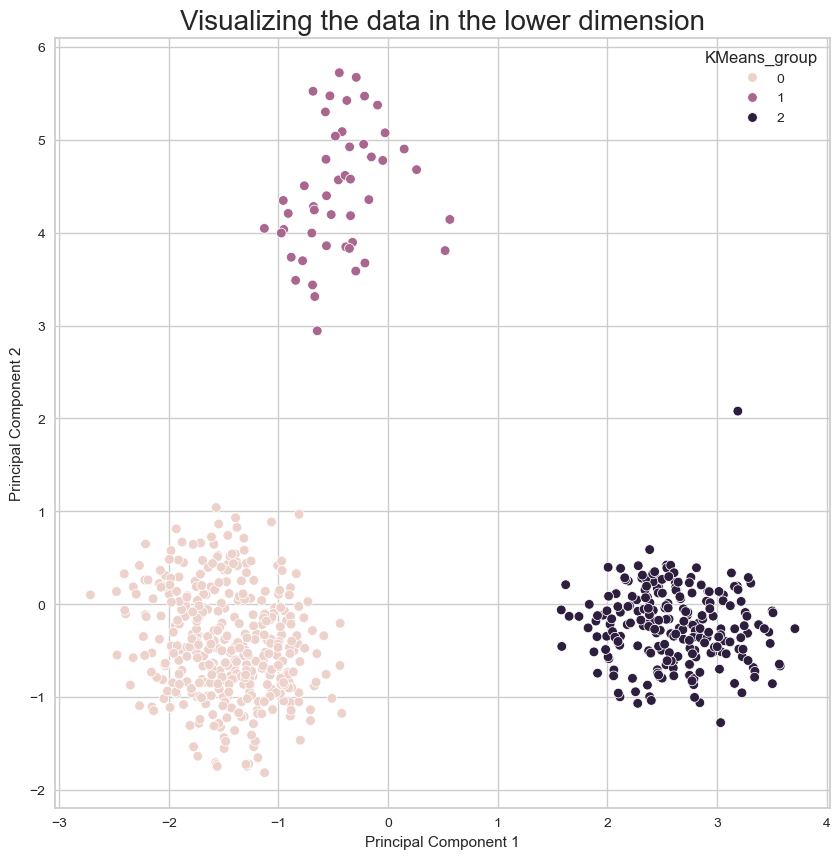

In [223]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=pca_df, x="Principal Component 1", y="Principal Component 2", hue=df.KMeans_group
)
plt.title("Visualizing the data in the lower dimension", fontsize=20)
# Save the figure before showing it
plt.savefig('D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/pca_3.jpg', dpi=100)

# Show the figure
plt.show()

# Close the figure to free memory
plt.close()

In [224]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_data_2 = pca.fit_transform(df_scaled)
pca_df_2 = pd.DataFrame(
    data=pca_data_2, columns=["Principal Component 1", "Principal Component 2", "Principal Component 3"]
)
pca_df_2.head()

Principal Component 1  Principal Component 2  Principal Component 3
0              -1.063321               0.885906               2.818081
1               3.190928               2.078843              -0.385822
2              -0.811453               0.968915               0.370591
3              -0.437318              -0.205101               0.746867
4               0.563894               4.141359               0.124247

In [225]:
print(
    "Explained variance per principal component: {}".format(
        pca.explained_variance_ratio_
    )
)

Explained variance per principal component: [0.56091846 0.28215907 0.04928464]


In the above result, the explained variance is shown.

- The first principal component explains 56.1% of total variance in the data.
- The second principal component explains 28.2% of total variance in the data.
- The third principal component explains 4.92% of total variance in the data.

In [344]:
df

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            100000.0                   2                  1   
1             50000.0                   3                  0   
2             50000.0                   7                  1   
3             30000.0                   5                  1   
4            100000.0                   6                  0   
..                ...                 ...                ...   
655           99000.0                  10                  1   
656           84000.0                  10                  1   
657          105000.0                   8                  1   
658          105000.0                  10                  1   
659          105000.0                   9                  0   

     Total_visits_online  Total_calls_made  KMeans_group  Hierarchical_group  
0                      1                 0             0                   0  
1                     10                 9             2                   2  
2                      3                 4             0                   0  
3                      1                 4             0                   0  
4                     12                 3             1                   1  
..                   ...               ...           ...                 ...  
655                   10                 0             1                   1  
656                   13                 2             1                   1  
657                    9                 1             1                   1  
658                   15                 0             1                   1  
659                   12                 2             1                   1  

[660 rows x 7 columns]

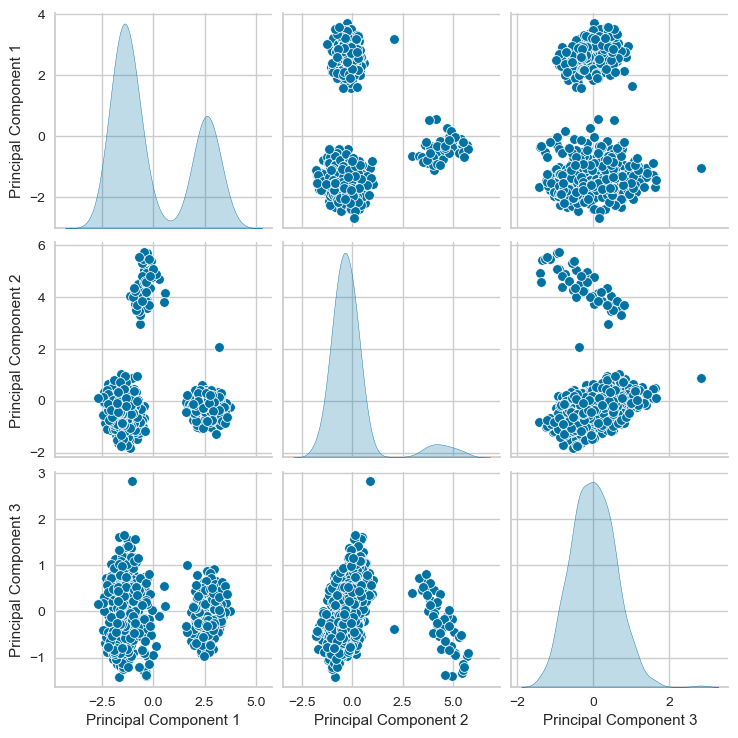

In [379]:
sns.pairplot(pca_df_2, diag_kind='kde')

plt.savefig('D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/pairrrplottt.jpg', dpi=100)

**Hierarchical Clustering on lower-dimensional data**

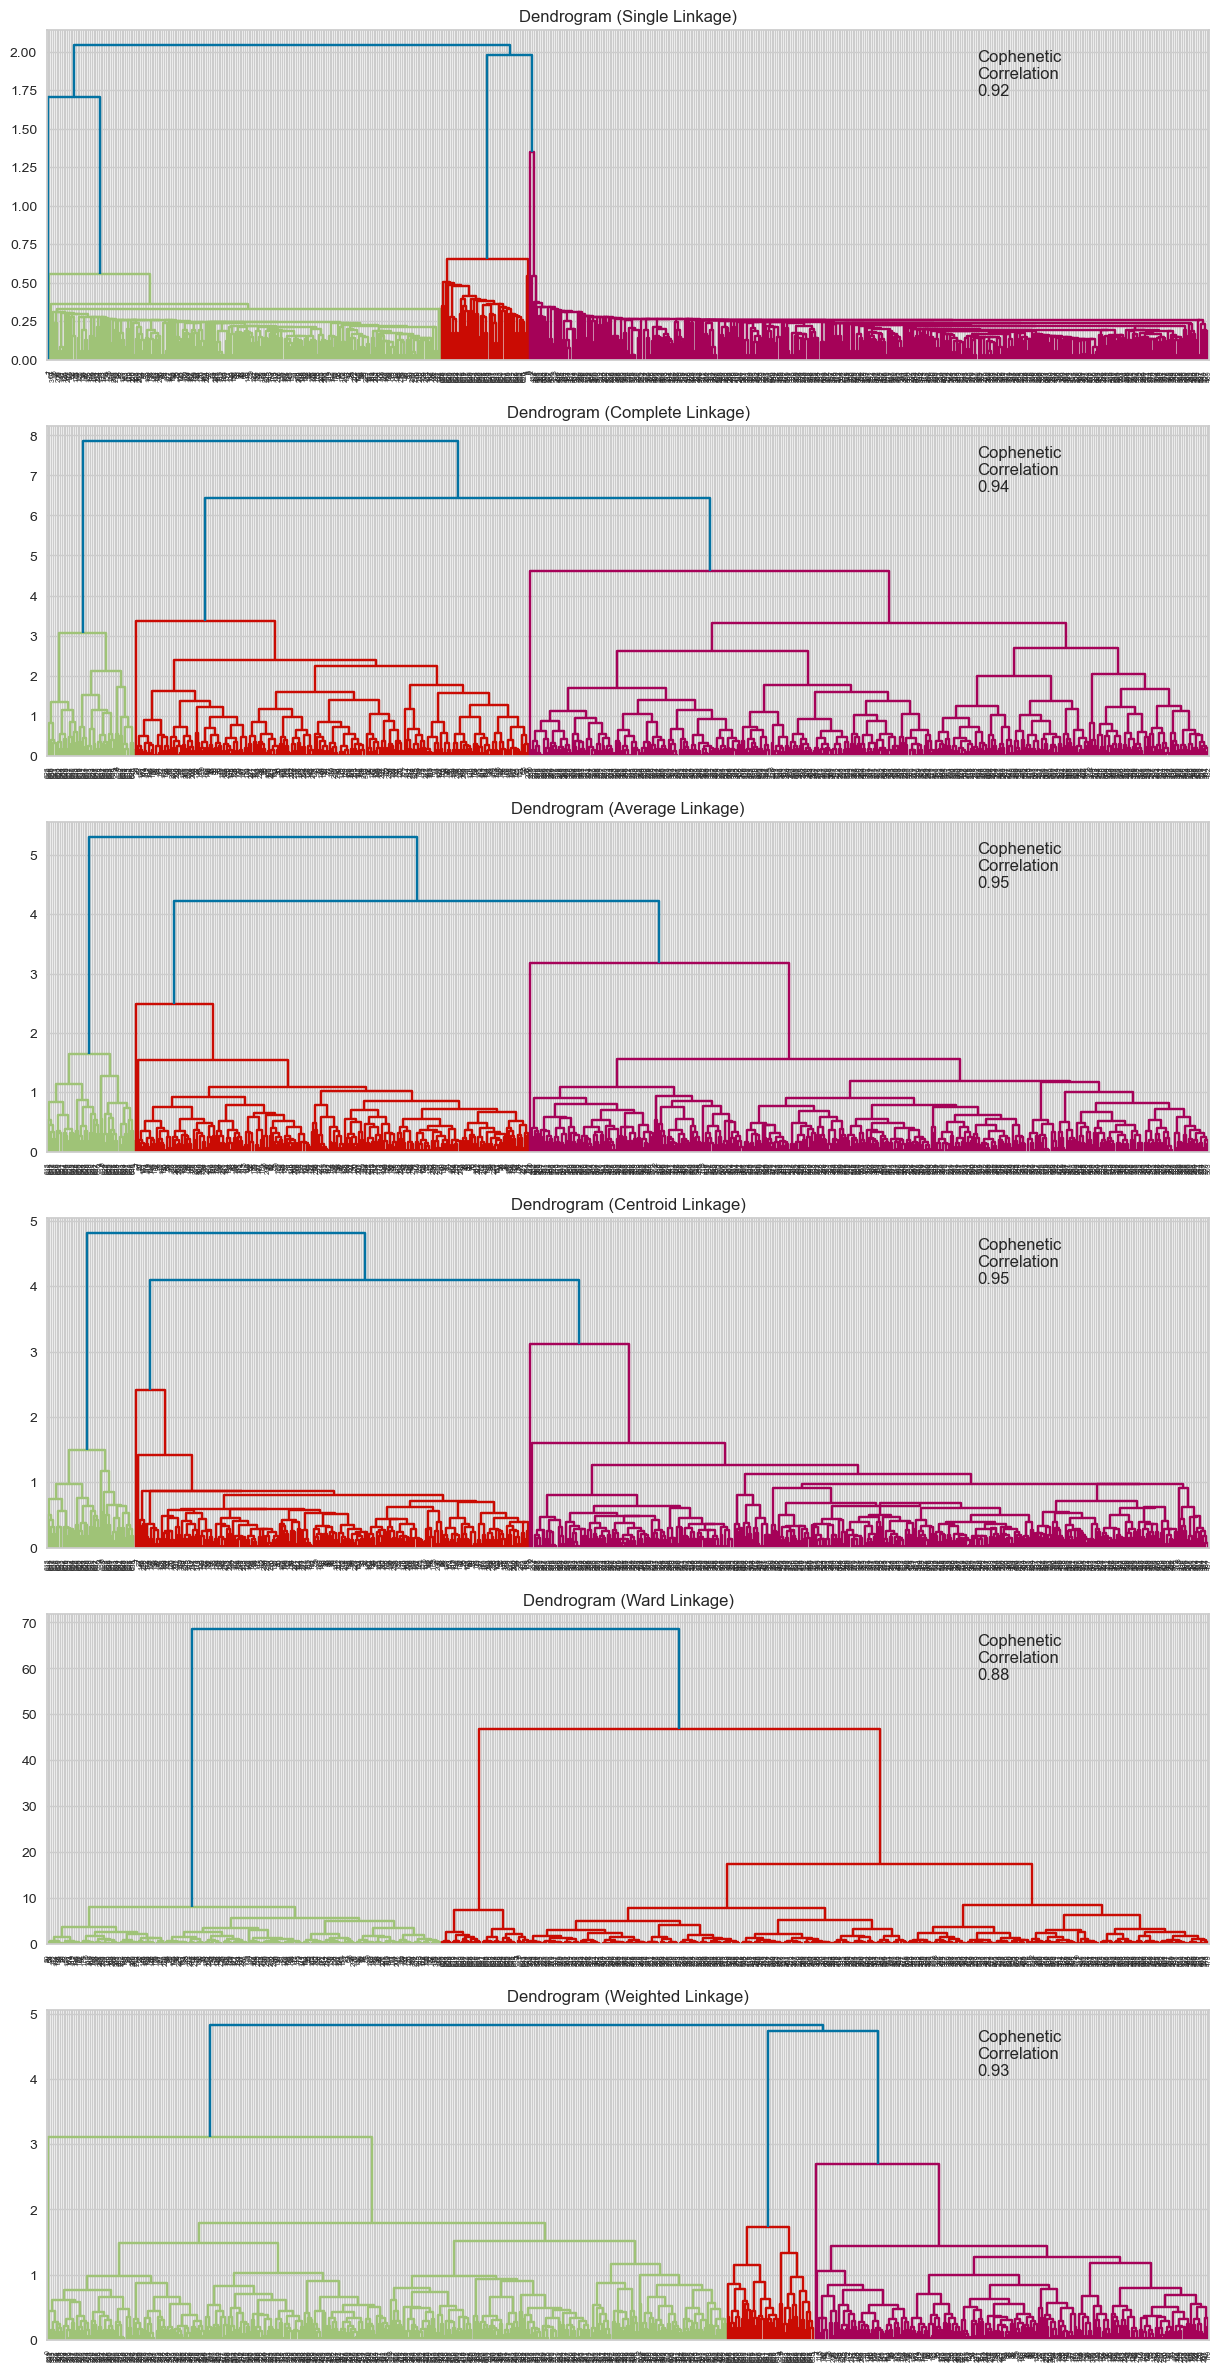

In [390]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(pca_df_2, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")
    coph_corr, coph_dist = cophenet(Z, pdist(pca_df_2))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

plt.savefig('D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/Dendrogram_pca.jpg', dpi=100)

## Observations

- The cophenetic correlation is highest for **average** and **centroid linkage**.
- **Average linkage** is preferred as it forms distinct clusters with a cophenetic correlation of **0.95** 
- The **dendrogram** suggests **3 clusters** as the optimal choice for complete linkage.


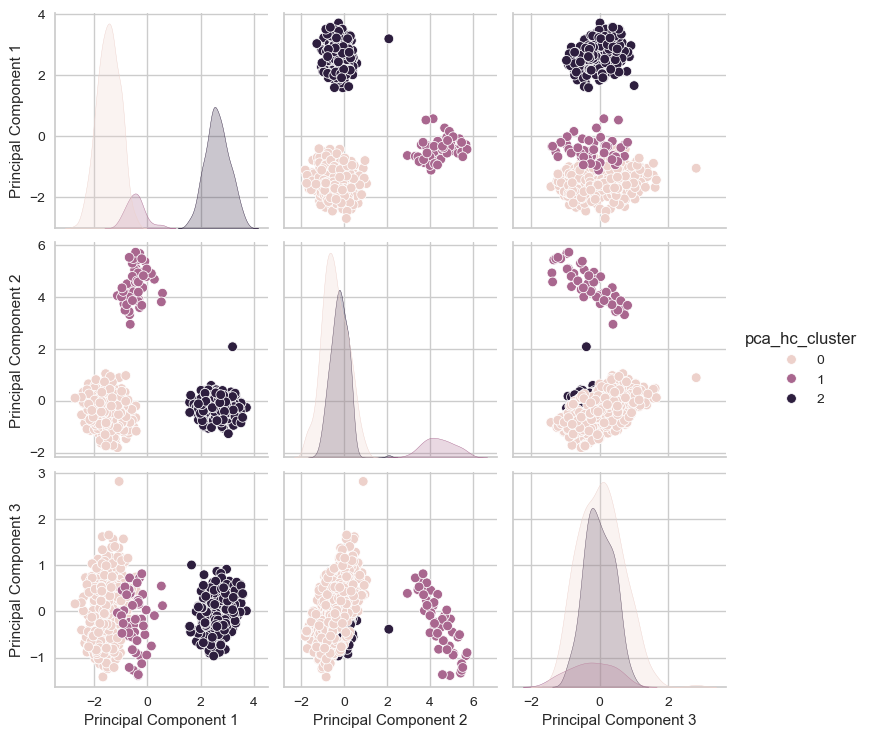

In [400]:
hc = AgglomerativeClustering(n_clusters=3, linkage="average")
hc_labels = hc.fit_predict(pca_df_2)
# adding hierarchical cluster labels to the original dataframe

pca_df_2['pca_hc_cluster'] = hc_labels
sns.pairplot(pca_df_2,diag_kind='kde',hue='pca_hc_cluster');

plt.savefig('D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/pairplot_pca.jpg', dpi=100)

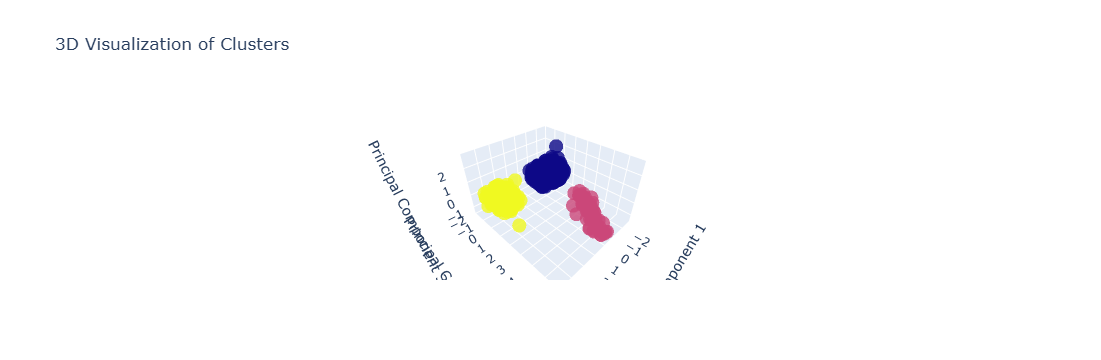

In [418]:
import plotly.graph_objs as go
import plotly.io as pio

# Create a 3D scatter plot
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=pca_df_2["Principal Component 1"],
            y=pca_df_2["Principal Component 2"],
            z=pca_df_2["Principal Component 3"],
            mode="markers",
            marker=dict(
                color=pca_df_2["pca_hc_cluster"],  # Coloring by cluster group
                size=8,
                opacity=0.8,
            ),
        )
    ]
)

# Customize layout
fig.update_layout(
    title="3D Visualization of Clusters",
    scene=dict(
        xaxis_title="Principal Component 1",
        yaxis_title="Principal Component 2",
        zaxis_title="Principal Component 3",
    ),
)

# Save the figure
pio.write_image(fig, "D:/Data Science/Module-6_Unsupervised_Learning/images_for_project/pca_3d2.jpg", scale=2)
py.offline.iplot(fig)
# Show the figure
# fig.show()
